# <p align=center> Détecter des Faux Billets avec Python <p>

<p align=center><img src="https://user.oc-static.com/upload/2020/11/25/16063163322759_Screen%20Shot%202020-11-05%20at%2011.15.15.png" alt="Logo ONCFM" width="500" title=""><p>

**Contexte** : L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM,
est une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros.

Dans le
cadre de cette lutte, nous souhaitons mettre en place un algorithme qui
soit capable de différencier automatiquement les vrais des faux billets.

## Sommaire :
1. Préparation des données
2. Analyse préliminaire des données
3. Correction de la donnée Margin_Low par Régression Linéaire
4. Algorithmes et prédictions\
    4.1. Prédiction par Régression Logistique et Evaluation\
    4.2. Prédiction par K-NN et Evaluation\
    4.3. Prédiction par K-means et Evaluation\
5. Choix de l’algorithme et Test final sur données fournies\

## 1. Prépartion des données

##### **Import des librairies et définition des fonctions**

In [1]:
# Import des librairies usuelles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
sns.set(style="darkgrid",palette='RdYlGn')
palet = {"red","green"}

import math

#Régression Linéaire
import scipy.stats as st
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Régression logistique, K-nn et KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve,auc
from sklearn.mixture import GaussianMixture

#Librairie qui gère les warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
# Définition des fonctions utilisées

separateur = "\n---------------------------------------------"

#Visualisation préliminaire des données
def Nettoyage (x):
    print(x.head(3), separateur)
    print("Shape\n",x.shape, separateur )
    print("Types\n", x.dtypes ,separateur)
    print("Valeurs Nulles\n",x.isnull().sum(),separateur )
    print("Nombre de doublons\n",x.duplicated().sum(),separateur)
    return


#Analyse univariée
def univariée(df,col):
    # Visualisation en Boxplot
    plt.figure(figsize=(10,3))
    sns.boxplot(df,x=df[col])
    plt.title(f"Distribution : {col}")
    plt.show()
    print('\n')
    #Valeurs remarquables
    print(f"Nombre de Valeurs : {len(df[col])}")
    print(f"Valeur minimale : {df[col].min()}")
    print(f"Valeur maximale : {df[col].max()}")
    print(f"Moyenne : {round(df[col].mean(),2)}")
    print(f"Médiane : {df[col].median()}")
    print(f"Variance : {round(df[col].std(),2)}")
    print('\n')
    #Détéction des outliers
    #1er quartile
    q1 = df[col].quantile(0.25)
    #3eme quartile
    q3 = df[col].quantile(0.75)
    #écart interquatile
    iqr = q3 - q1
    print('Ecart interquatile =', round(iqr,2))
    seuil_min = q1 -(1.5 * iqr) 
    seuil_max = q3 +(1.5 * iqr)
    print('Seuil minimum =', round(seuil_min,2))
    print('Seuil maximum =', round(seuil_max,2))
    #dataframe des outliers
    dfo = df[(df[col] < seuil_min) | (df[col] > seuil_max)]
    #liste des outliers
    liste_out=dfo.index
    print("Nombre d'outliers:", len(liste_out))
    print(dfo.index.tolist())
    print(separateur)
       
    #Test de Normalité de Shapiro-Wilk
    stat, p = st.shapiro(df[col])
    print(f"HO du test de Shapiro-Wilk : la variable {col} suit une distribution normale")
    print(f"Stat : {stat}")
    
    alpha = 0.05 # niveau de signification
    print(f"P-value =  {p}")
    if p > alpha:
        print("Acceptation de H0")
    else:
        print("Rejet de H0")
    return

def bivariée(df,col1,col2,hue):
    sns.scatterplot(df,x=df[col1],y=df[col2],hue=hue)
    sns.set(rc={"figure.figsize":(10, 10)})
    # plt.yscale('log')
    plt.title(f"Scatterplot entre les variables {col1} et {col2}")
    plt.show()
    #Test de Corrélation de Pearson
    stat, p = st.pearsonr(df[col1],df[col2])
    print(f"HO du test de Person : le coefficient de corrélation n'est pas significativement différent de zéro (il n'y a pas de relation linéaire) entre {col1} et {col2}")
    print(f"Corr : {stat}")
    
    alpha = 0.05 # niveau de signification
    print(f"P-value =  {p}")
    if p > alpha:
        print("Acceptation de H0")
    else:
        print("Rejet de H0")
    return



# Régression linaire multiple

def backward_selected(data, response):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    
    return model

#Recalcul des scores de prédictions en fonction de la/les colonnes enlevées
def scores_test_overfit(df,col):
    #On copie un nouveau dataframe sans la variable
    df_test_overfit=df.drop(columns=col)

    #On créer nos set d'entrainement et de test
    x_train1_over, x_test1_over, y_train_over, y_test_over = train_test_split(df_test_overfit,df_test_overfit['is_genuine'], test_size=test_size, random_state=2)
    x_train_over = x_train1_over.iloc[:,1:]
    x_test_over = x_test1_over.iloc[:,1:]
    #Regression logistique
    logisticReg_over = LogisticRegression()
    logisticReg_over.fit(x_train_over,y_train_over)
    y_pred_reglog_over = logisticReg_over.predict(x_test_over)
    #KNN
    X_train_std_over = sc_X.fit_transform(x_train_over)
    X_test_std_over = sc_X.fit_transform(x_test_over)
    knn_over = KNeighborsClassifier(n_neighbors=n_neighbors, p=2, metric='euclidean')
    knn_over.fit(X_train_std_over,y_train_over)
    Y_pred_knn_over = knn_over.predict(X_test_std_over)
    #Kmeans
    km_over=KMeans(n_clusters=2,init='random', max_iter=300, n_init=10, random_state=2)
    y_means_over = km_over.fit_predict(X_train_std_over)
    y_pred_km_over=km_over.predict(X_test_std_over)

    #Scores
    score_lr_over = metrics.accuracy_score(y_test_over,y_pred_reglog_over)
    score_knn_over = metrics.accuracy_score(y_test_over,Y_pred_knn_over)
    if metrics.accuracy_score(y_test_over,y_pred_km_over)>0.5:
        score_km_over = metrics.accuracy_score(y_test_over,y_pred_km_over)
    else : score_km_over = 1-metrics.accuracy_score(y_test_over,y_pred_km_over)


    print(f"Régression logistique : {round(score_lr_over*100,2)}% ,KNN : {round(score_knn_over*100,2)}% ,Kmeans : {round(score_km_over*100,2)}%")

#### **Import du jeu de donnée**

In [3]:
billets = pd.read_csv('billets.csv',sep=';')
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

Nous disposons actuellement de six informations géométriques sur un billet :
- length : la longueur du billet ;
- height_left : la hauteur du billet (mesurée sur le côté gauche) ;
- height_right : la hauteur du billet (mesurée sur le côté droit) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci ;
- margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci ;
- diagonal : la diagonale du billet.

Toutes ces données sont en millimètres.

In [4]:
columns = ['diagonal', 'height_left','height_right','margin_low', "margin_up", "length"]

## 2. Analyse préliminaire des données

In [5]:

Nettoyage(billets)


   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   

   length  
0  112.83  
1  113.09  
2  113.16   
---------------------------------------------
Shape
 (1500, 7) 
---------------------------------------------
Types
 is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object 
---------------------------------------------
Valeurs Nulles
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64 
---------------------------------------------
Nombre de doublons
 0 
---------------------------------------------


In [6]:
print(billets.groupby('is_genuine').count().T)

is_genuine    False  True 
diagonal        500   1000
height_left     500   1000
height_right    500   1000
margin_low      492    971
margin_up       500   1000
length          500   1000


Le DataSet continent donc :
- 7 variables
- Un boolean qui nous permet de voir l'authenticité du billet
- 1500 lignes (1000 billets authantiques et 500 contrefaits)
- 37 valeurs nulles pour la variable *margin_low* (8 False, 29 True)
- aucun doublon

Afin de continuer l'analyse de ces données, nous allons enlever les 37 lignes contenant des valeurs nulles. Nous les traiterons par la suite par Régression Lineaire afin de compléter les valeurs manquantes.

In [7]:
billets_sans_na = billets.dropna()

#### **Analyse du dataset sans valeurs nulles**

In [8]:
print(billets_sans_na.groupby('is_genuine').describe().T)


is_genuine               False       True 
diagonal     count  492.000000  971.000000
             mean   171.901402  171.988476
             std      0.305473    0.301402
             min    171.040000  171.040000
             25%    171.697500  171.790000
             50%    171.910000  171.990000
             75%    172.092500  172.200000
             max    173.010000  172.920000
height_left  count  492.000000  971.000000
             mean   104.188537  103.951679
             std      0.224418    0.301518
             min    103.510000  103.140000
             25%    104.040000  103.745000
             50%    104.180000  103.950000
             75%    104.330000  104.140000
             max    104.880000  104.860000
height_right count  492.000000  971.000000
             mean   104.143272  103.809094
             std      0.271683    0.288862
             min    103.430000  102.910000
             25%    103.950000  103.610000
             50%    104.160000  103.810000
           

On constate des ecarts entre les billets authentiques et contrefaits. Calculons ces ecarts.

In [9]:
group = billets_sans_na.groupby('is_genuine').mean().T.reset_index()
group['Ecart'] = round((group[False]-group[True])/group[True]*100,2)
group

is_genuine         index       False        True  Ecart
0               diagonal  171.901402  171.988476  -0.05
1            height_left  104.188537  103.951679   0.23
2           height_right  104.143272  103.809094   0.32
3             margin_low    5.215935    4.116097  26.72
4              margin_up    3.351504    3.052544   9.79
5                 length  111.632114  113.203059  -1.39

Cet affichage nous permet de voir un ecart significatif sur les variables *margin_low* et *margin_up* entre les billets authantiques et les billets contrefaits.

##### **Analysons chaque variable**

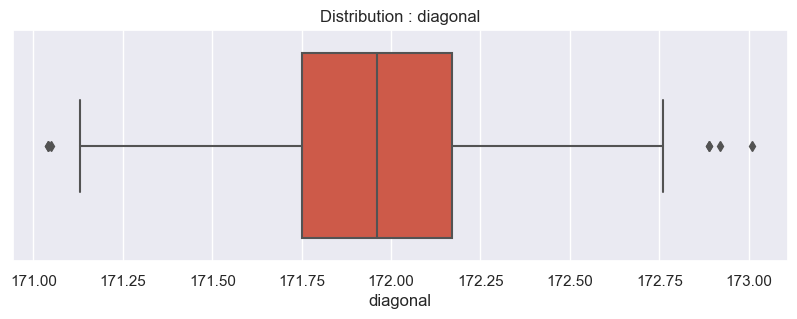



Nombre de Valeurs : 1463
Valeur minimale : 171.04
Valeur maximale : 173.01
Moyenne : 171.96
Médiane : 171.96
Variance : 0.31


Ecart interquatile = 0.42
Seuil minimum = 171.12
Seuil maximum = 172.8
Nombre d'outliers: 7
[729, 828, 842, 1022, 1142, 1277, 1388]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable diagonal suit une distribution normale
Stat : 0.9985674023628235
P-value =  0.2687021493911743
Acceptation de H0


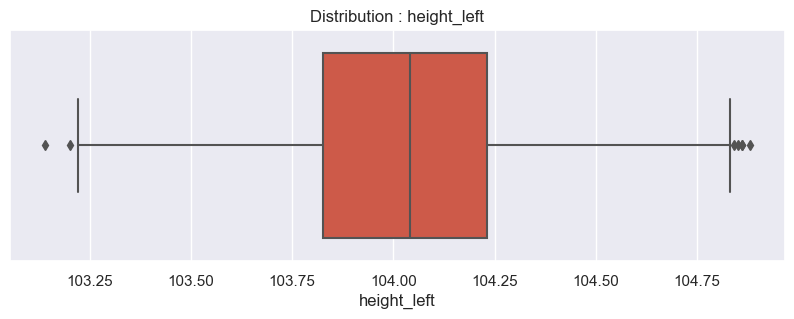



Nombre de Valeurs : 1463
Valeur minimale : 103.14
Valeur maximale : 104.88
Moyenne : 104.03
Médiane : 104.04
Variance : 0.3


Ecart interquatile = 0.41
Seuil minimum = 103.22
Seuil maximum = 104.84
Nombre d'outliers: 7
[0, 224, 292, 1090, 1150, 1310, 1382]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable height_left suit une distribution normale
Stat : 0.9979027509689331
P-value =  0.05763062462210655
Acceptation de H0


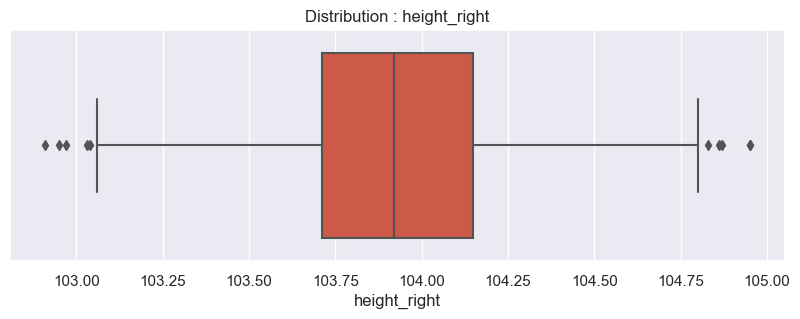



Nombre de Valeurs : 1463
Valeur minimale : 102.91
Valeur maximale : 104.95
Moyenne : 103.92
Médiane : 103.92
Variance : 0.32


Ecart interquatile = 0.44
Seuil minimum = 103.05
Seuil maximum = 104.81
Nombre d'outliers: 10
[0, 77, 176, 193, 522, 761, 1199, 1321, 1331, 1484]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable height_right suit une distribution normale
Stat : 0.9994353652000427
P-value =  0.9576431512832642
Acceptation de H0


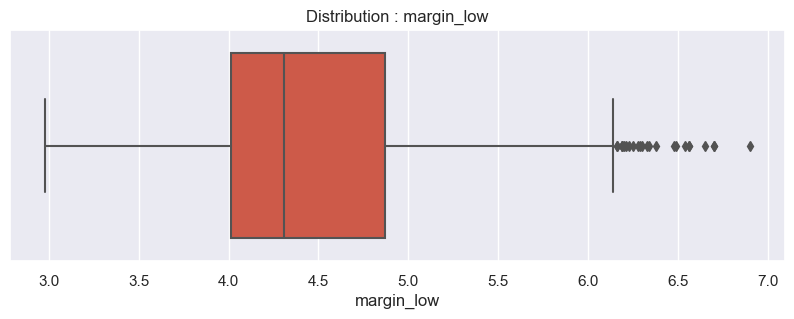



Nombre de Valeurs : 1463
Valeur minimale : 2.98
Valeur maximale : 6.9
Moyenne : 4.49
Médiane : 4.31
Variance : 0.66


Ecart interquatile = 0.86
Seuil minimum = 2.73
Seuil maximum = 6.15
Nombre d'outliers: 24
[1023, 1027, 1031, 1041, 1053, 1075, 1092, 1110, 1124, 1133, 1134, 1169, 1254, 1290, 1322, 1345, 1348, 1353, 1420, 1426, 1441, 1459, 1464, 1473]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable margin_low suit une distribution normale
Stat : 0.9377837181091309
P-value =  2.8283876088209786e-24
Rejet de H0


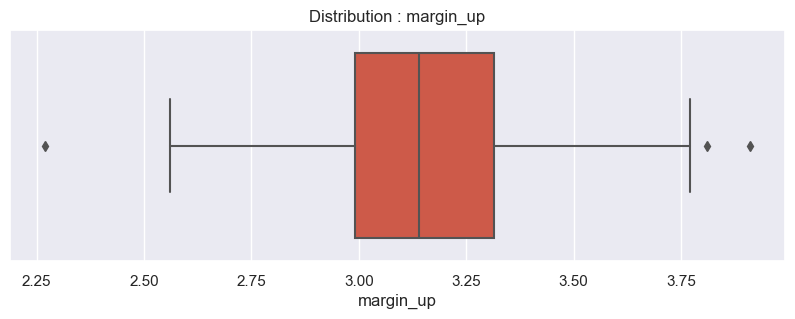



Nombre de Valeurs : 1463
Valeur minimale : 2.27
Valeur maximale : 3.91
Moyenne : 3.15
Médiane : 3.14
Variance : 0.23


Ecart interquatile = 0.32
Seuil minimum = 2.5
Seuil maximum = 3.8
Nombre d'outliers: 3
[664, 1029, 1270]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable margin_up suit une distribution normale
Stat : 0.9958276152610779
P-value =  0.0004760113952215761
Rejet de H0


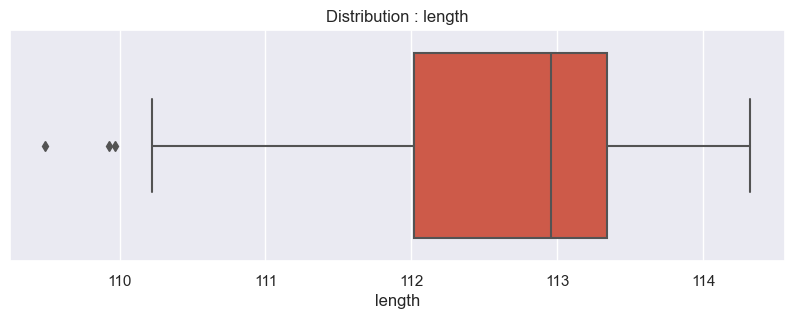



Nombre de Valeurs : 1463
Valeur minimale : 109.49
Valeur maximale : 114.32
Moyenne : 112.67
Médiane : 112.96
Variance : 0.87


Ecart interquatile = 1.32
Seuil minimum = 110.04
Seuil maximum = 115.32
Nombre d'outliers: 3
[1082, 1355, 1453]

---------------------------------------------
HO du test de Shapiro-Wilk : la variable length suit une distribution normale
Stat : 0.9163141250610352
P-value =  1.0767076021107087e-27
Rejet de H0


In [10]:
#Boucle sur toutes les colonnes à valeurs quantitatives pour analyse univariée
for col in billets_sans_na.select_dtypes(include=['float']).columns:
    univariée(billets_sans_na,col)

*Margin_up*, *margin_low* et *length* ne suivent pas une distribution normale.\
Nous trouvons un très faible pourcentage d'outliers.



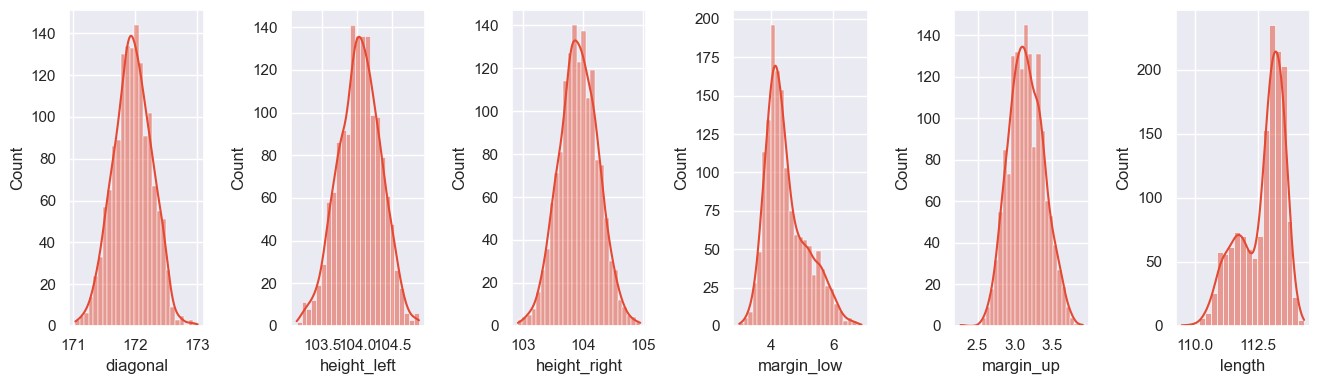

In [11]:
#Visualisation de la Distribution pour chaque variable


plt.figure(figsize=(20,4), dpi=100)
plt.title('Distribution des Variables')
i = 1
for col in columns:
    plt.subplot(1,9,i)
    sns.histplot(billets_sans_na[col],kde=True)
    i += 1
plt.tight_layout()
plt.show()



Skewenss et Kurtosis

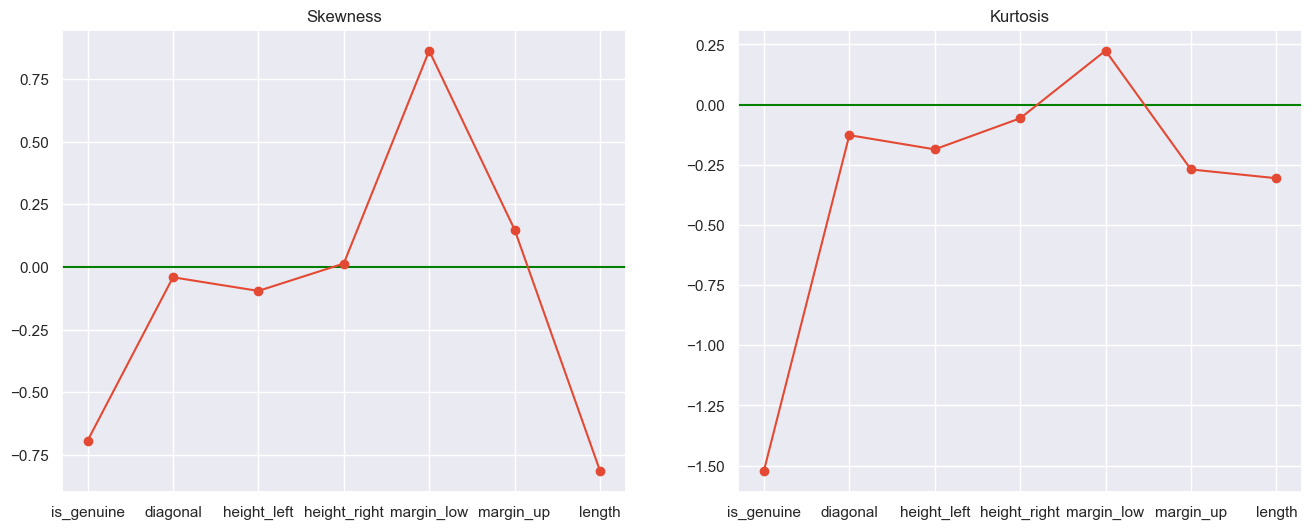

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.axhline(y=0, color="g", linestyle='-')
ax1.set_title("Skewness")
ax1.plot(billets_sans_na.skew(), linestyle='-', marker='o');
ax2.axhline(y=0, color="g", linestyle='-')
ax2.set_title("Kurtosis")
ax2.plot(billets_sans_na.kurt(), linestyle='-', marker='o');

plt.show()

Que nous apprends ces graphs (on ne tient pas compte de la variable *is_genuine*)?
- Skewness : 
    - Distribution symétrique pour *height_right*, quasi symétrique pour *diagonal*,*height_left* et *margin_up*
    - Distribution étalée à droite pour *margin_low*
    - Distribution étalée à gauche pour *length*
- Kurtosis :
    - Distribution moins aplatie que la normale pour *margin_low*
    - Distribution presque normale pour *height_right*
    - Distribution plus aplatie que la normale pour les autres


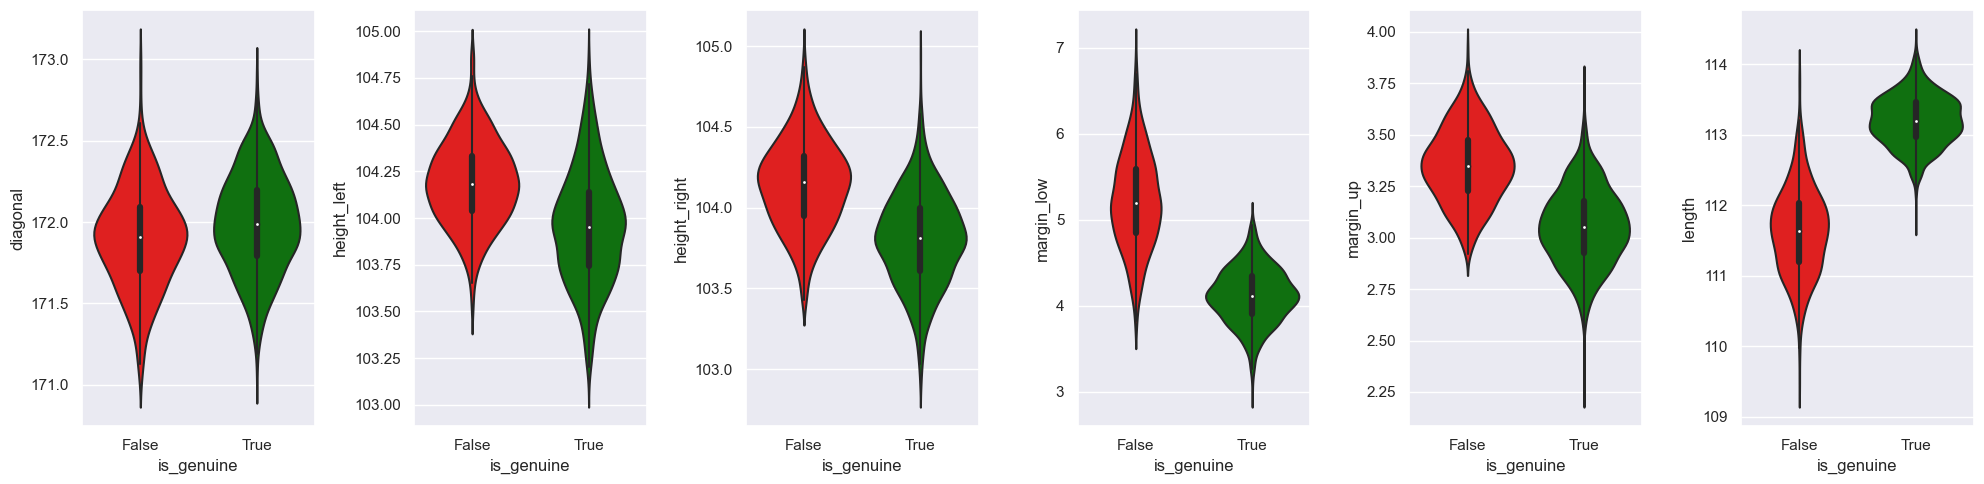

In [13]:
# Visualisation en fonction de l'authenticité en Violinplot
plt.figure(figsize=(20,5), dpi=100)
sns.set_palette(palet)
i=1
for col in columns:
    plt.subplot(1,6,i)
    sns.violinplot(billets_sans_na,y=col,x='is_genuine')
    i += 1
plt.tight_layout()

plt.show()


Cette visualisation montre une distribution différenciante au niveau des variables *margin_low* et *length*.

##### **Visualisons les variables 2 à 2**

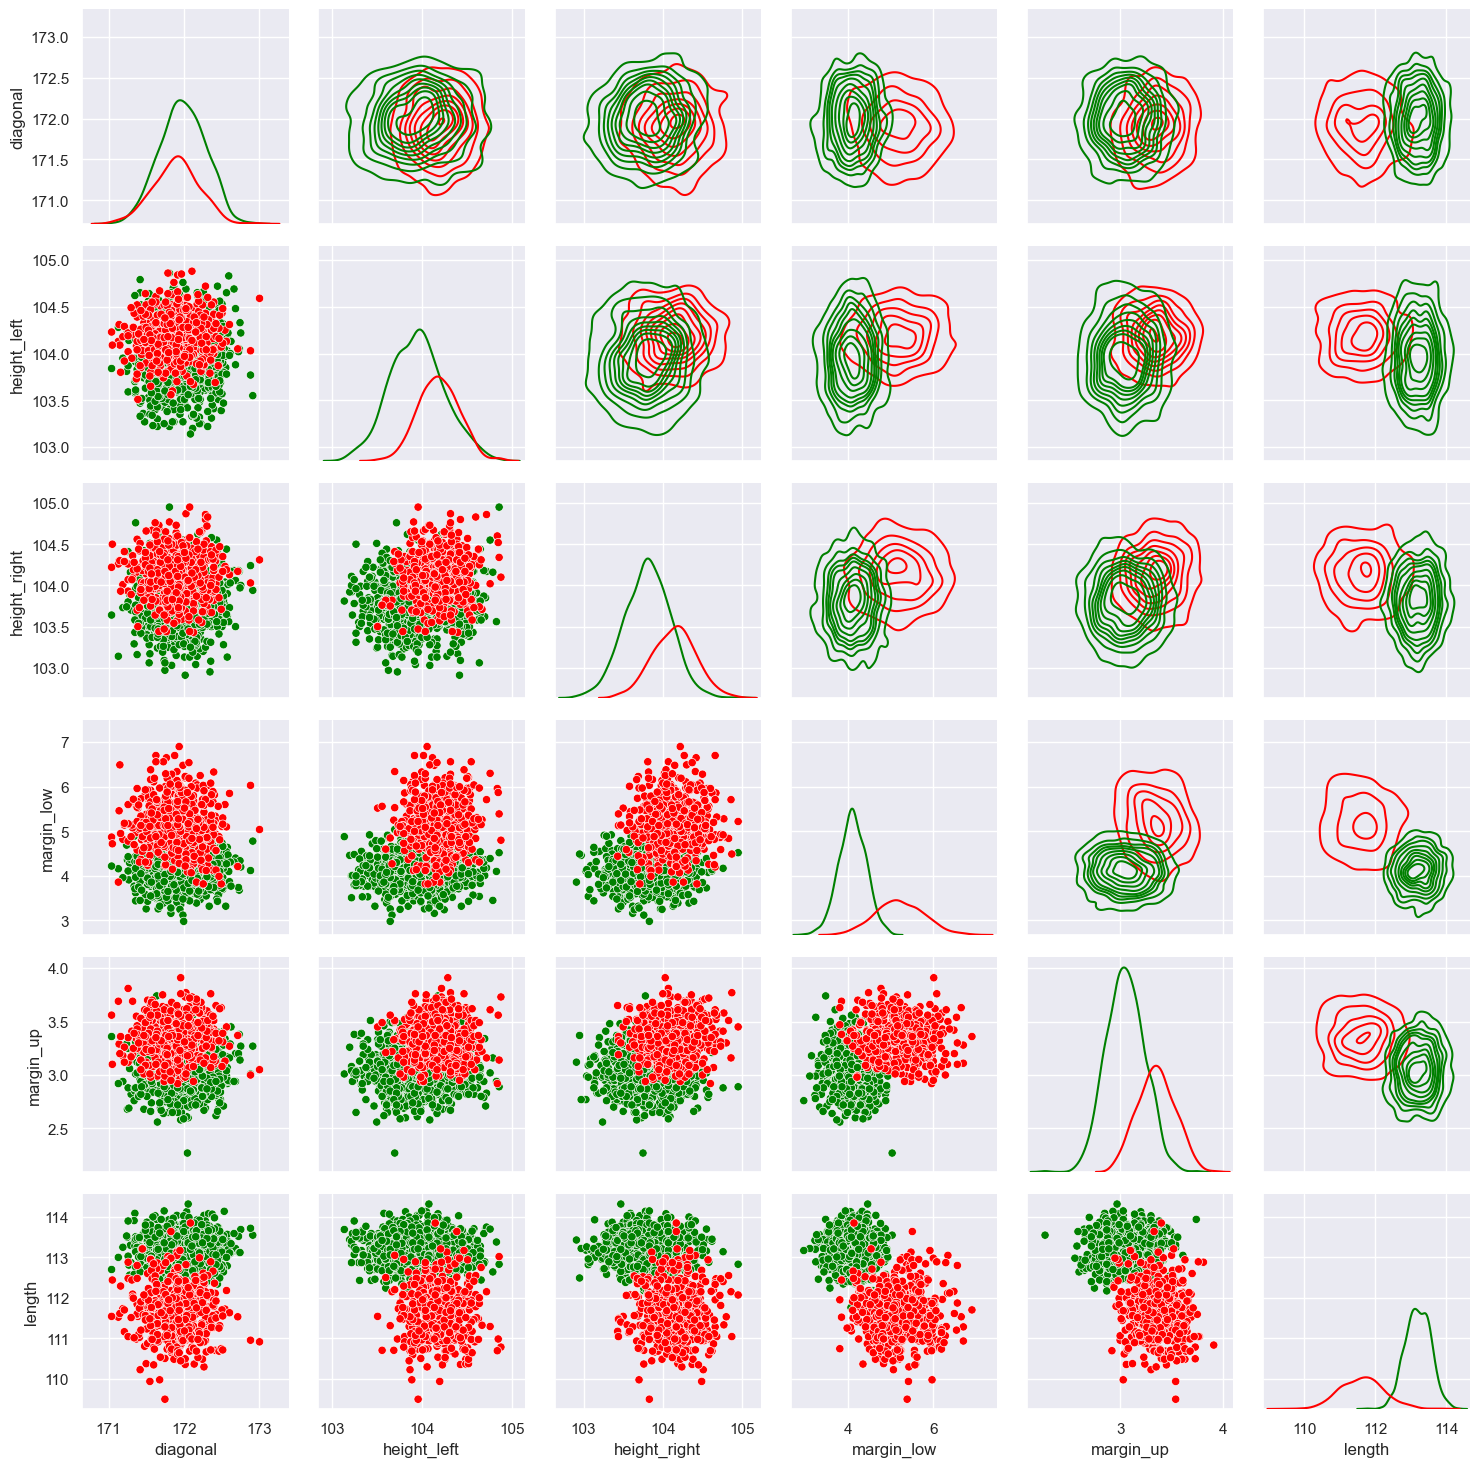

In [14]:
sns.set_palette(palet)
g=sns.PairGrid(billets_sans_na,hue='is_genuine')
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.show()

Nous voyons que les couples suivants permettent une discrimination de l'authenticité (du plus efficace au moins efficace):
- *margin_low* / *lenght*
- *margin_up* / *lenght*
- *margin_low* / *margin_up*

Analysons ces 3 couples.

**Analyse bivariée *margin_low* / *lenght***

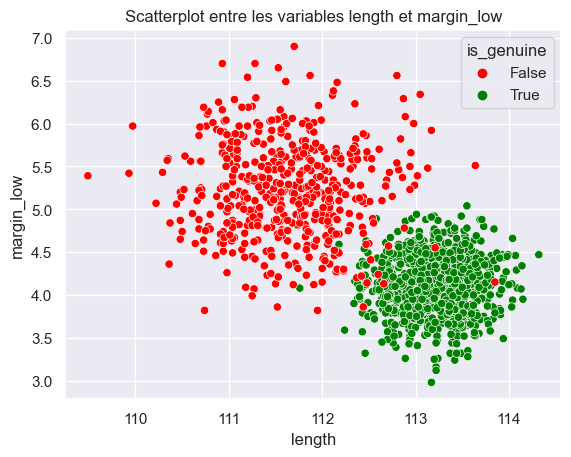

HO du test de Person : le coefficient de corrélation n'est pas significativement différent de zéro (il n'y a pas de relation linéaire) entre length et margin_low
Corr : -0.6667527808935999
P-value =  8.975567091004803e-189
Rejet de H0


In [15]:
sns.set_palette(palet)
bivariée(billets_sans_na,'length','margin_low',hue='is_genuine')

Nous avons une corrélation entre *margin_low* et *lenght*.

**Analyse bivariée de *margin_up* / *lenght***

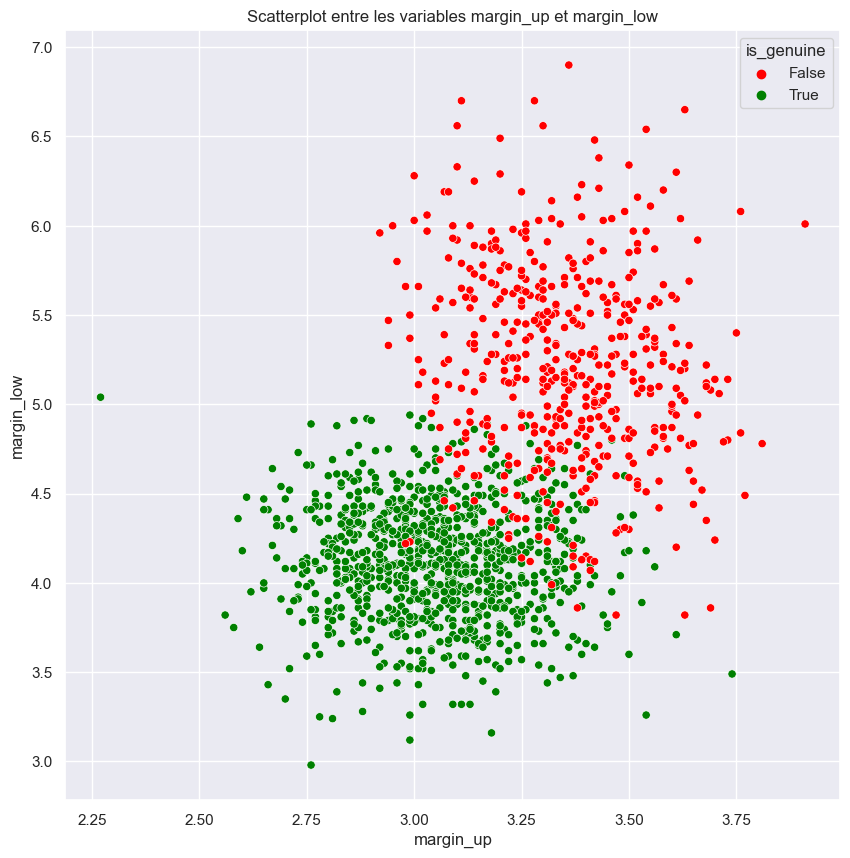

HO du test de Person : le coefficient de corrélation n'est pas significativement différent de zéro (il n'y a pas de relation linéaire) entre margin_up et margin_low
Corr : 0.43160607332031425
P-value =  1.9216040183028643e-67
Rejet de H0


In [16]:
sns.set_palette(palet)
bivariée(billets_sans_na,'margin_up','margin_low',hue='is_genuine')

Nous avons bien une corrélation entre *margin_low* et *margin_up*.

**Analyse bivariée *margin_low* / *margin_up***

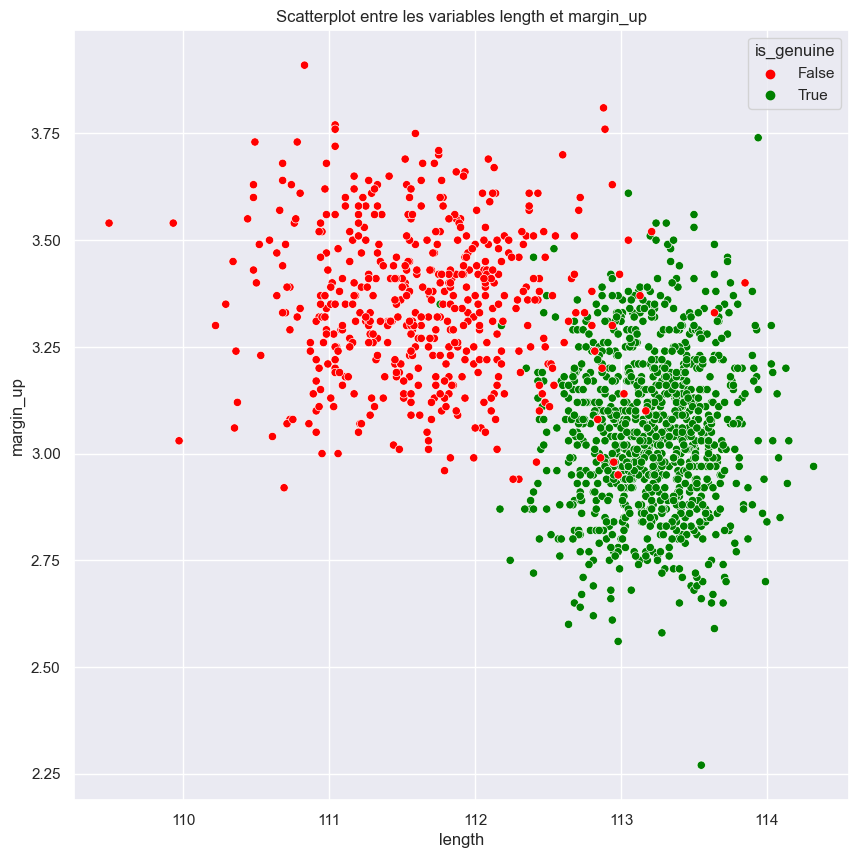

HO du test de Person : le coefficient de corrélation n'est pas significativement différent de zéro (il n'y a pas de relation linéaire) entre length et margin_up
Corr : -0.5211389138131246
P-value =  1.1728230541178858e-102
Rejet de H0


In [17]:
sns.set_palette(palet)
bivariée(billets_sans_na,'length','margin_up',hue='is_genuine')

Nous avons également une corrélation entre *margin_low* et *margin_up*.

Visualisons la corréalation des variables dans une matrice de corrélation.

##### **Martice de Corrélation**

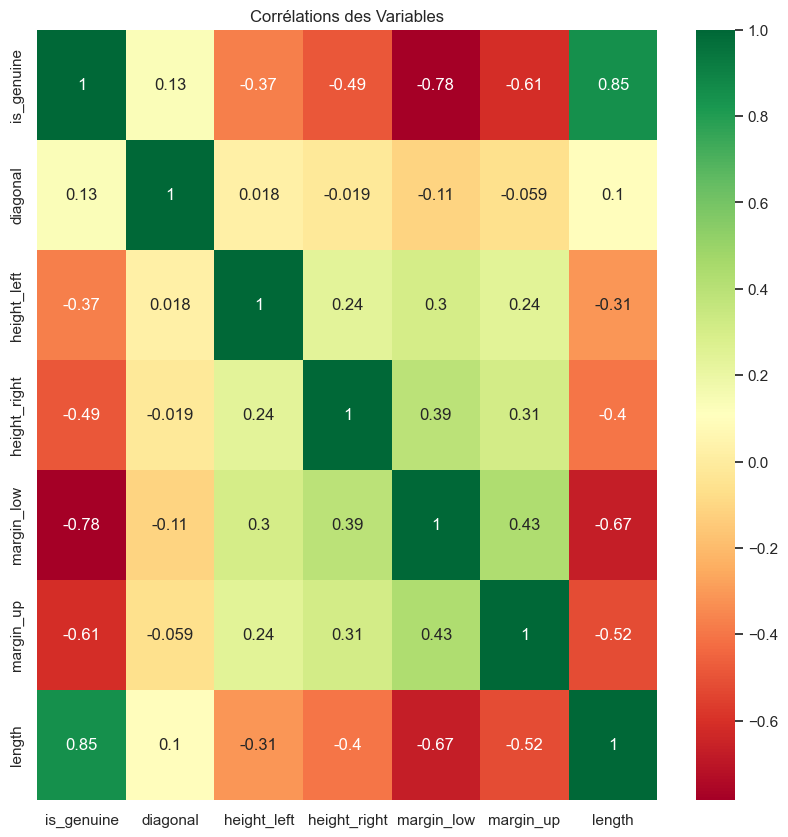

In [18]:
sns.heatmap(billets_sans_na.corr(), cmap="RdYlGn", annot=True).set_title('Corrélations des Variables')
plt.show()

Nous voyons une confirmation des conclusions tirées précédement.
- *length* est très coorélée à l'authenticité, *margin_low* et *margin_up* sont négativement corrélées.
- *Margin_low* et *length* sont très négativement corélées.

## 3. Correction de la donnée *margin_Low* par Régression Linéaire

Nous allons réaliser une **Régression Linéaire multivariable** sur tout le dataset, ainsi qu'une multivariable en séparant les *True* et les *False* et nous implémenterons en fonction des résultats.

In [19]:
#Séparation du dataset pour analyse

#Billets sans valeurs nulles
billets_True = billets[billets['is_genuine']==True].dropna()
billets_False = billets[billets['is_genuine']==False].dropna()
#Billets contenant uniquement les valeurs nulles
billets_TrueNA = billets[(billets['is_genuine']==True)&billets['margin_low'].isnull()]
billets_FalseNA = billets[(billets['is_genuine']==False)&billets['margin_low'].isnull()]
billetsNA = billets[billets['margin_low'].isnull()]


Nous appliquons la methode **Backward Selection**.

#### **Régression linéaire multivariable sur tout le dataset**

In [20]:
reg_backward_All = backward_selected(billets_sans_na[columns], 'margin_low')

_______________________________
margin_low ~ height_right + margin_up + length + diagonal + height_left + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          2.60e-202
Time:                        11:36:19   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

Nous avons des résultats assez faibles.

#### **Régression linéaire multivariable en séparant en fonction de l'authanticité**

**Régression linéaire sur les *True***

In [21]:
reg_backward_True = backward_selected(billets_True[columns], 'margin_low')

_______________________________
margin_low ~ height_right + margin_up + length + diagonal + height_left + 1
remove height_left (p-value : 0.895 )

_______________________________
margin_low ~ height_right + margin_up + length + diagonal + 1
remove height_right (p-value : 0.308 )

_______________________________
margin_low ~ margin_up + length + diagonal + 1
remove diagonal (p-value : 0.216 )

_______________________________
margin_low ~ margin_up + length + 1
remove length (p-value : 0.21 )

_______________________________
margin_low ~ margin_up + 1
remove margin_up (p-value : 0.06 )

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.558
Date:                Tue, 29 Aug 2023   Prob (F-statistic):             0.0596
Time:        

**Régression linéaire sur les *False***

In [22]:
reg_backward_False = backward_selected(billets_False[columns], 'margin_low')

_______________________________
margin_low ~ height_right + margin_up + length + diagonal + height_left + 1
remove height_right (p-value : 0.977 )

_______________________________
margin_low ~ margin_up + length + diagonal + height_left + 1
remove length (p-value : 0.352 )

_______________________________
margin_low ~ margin_up + diagonal + height_left + 1
remove height_left (p-value : 0.364 )

_______________________________
margin_low ~ margin_up + diagonal + 1
remove diagonal (p-value : 0.184 )

_______________________________
margin_low ~ margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     10.15
Date:                Tue, 29 Aug 2023   Prob (F-statistic):            0.00154
Time:               

Les résultats sont très médiocres. La prédiction est de mauvaise qualité et revient finalement à une régression linéaire simple sur la variable margin_up.

Nous choisissons de garder la prédiction sur tout le dataset.

#### **Analysons les résultats de la régression linéaire**

In [23]:
alpha = 0.05
n_All = billets_sans_na.shape[0]
p=6

Visualisons la droite de régression linéaire

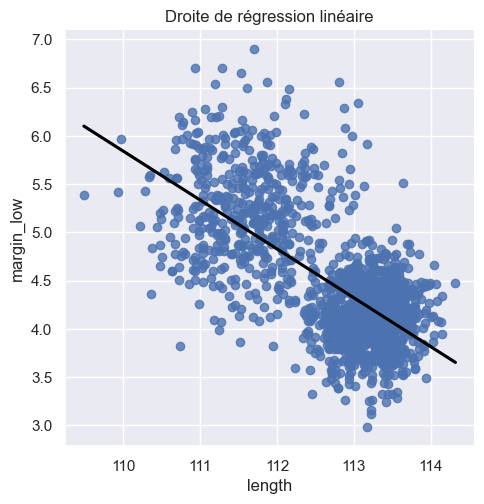

In [24]:
ax = sns.lmplot(x="length", y="margin_low", data=billets_sans_na, ci=None, line_kws={'color':'black'})
ax.set(xlabel='length', ylabel='margin_low')
plt.title('Droite de régression linéaire')
plt.show()

#### **Colinéarité des variables**

Vérifions l'éventuelle colinéarité approchée des variables :

In [25]:
variables = reg_backward_All.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.230114515556036,
 1.404403778184362,
 1.5769501453665835,
 1.0136128990686308,
 1.1382605736082498]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### **Homoscédasticité**

Testons l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [26]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_backward_All.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216183352e-16


La p-valeur ici est  inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testons la normalité des résidus



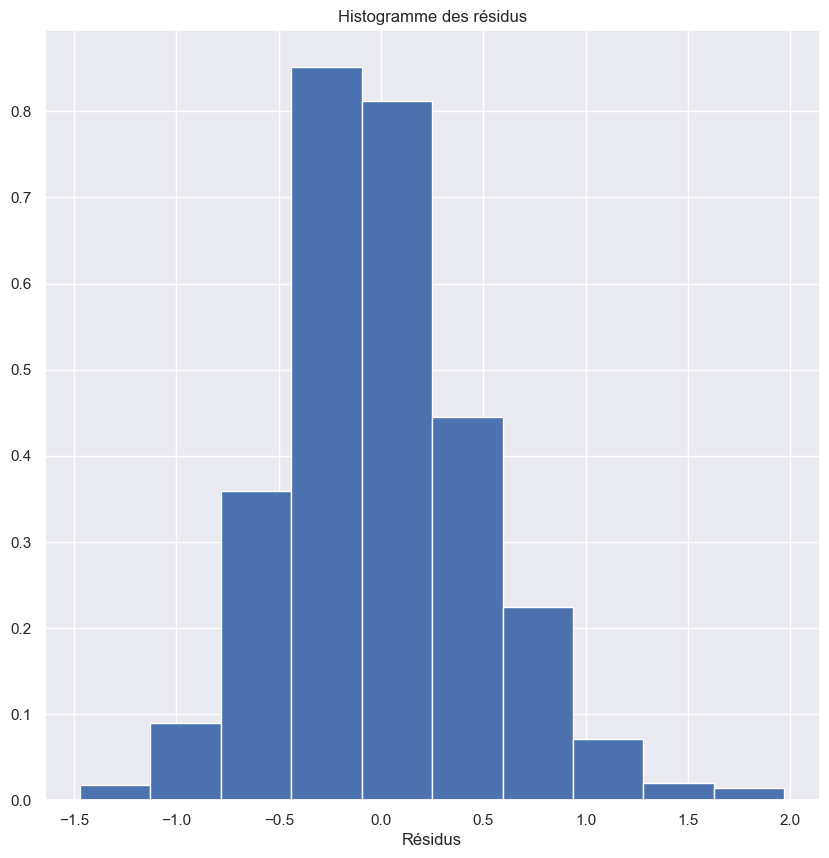

In [27]:
#Visualisons les résidus
billets_sans_na['residus'] = reg_backward_All.resid

plt.hist(billets_sans_na['residus'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()



La distribution semble proche de la normale et symétrique autour de 0.

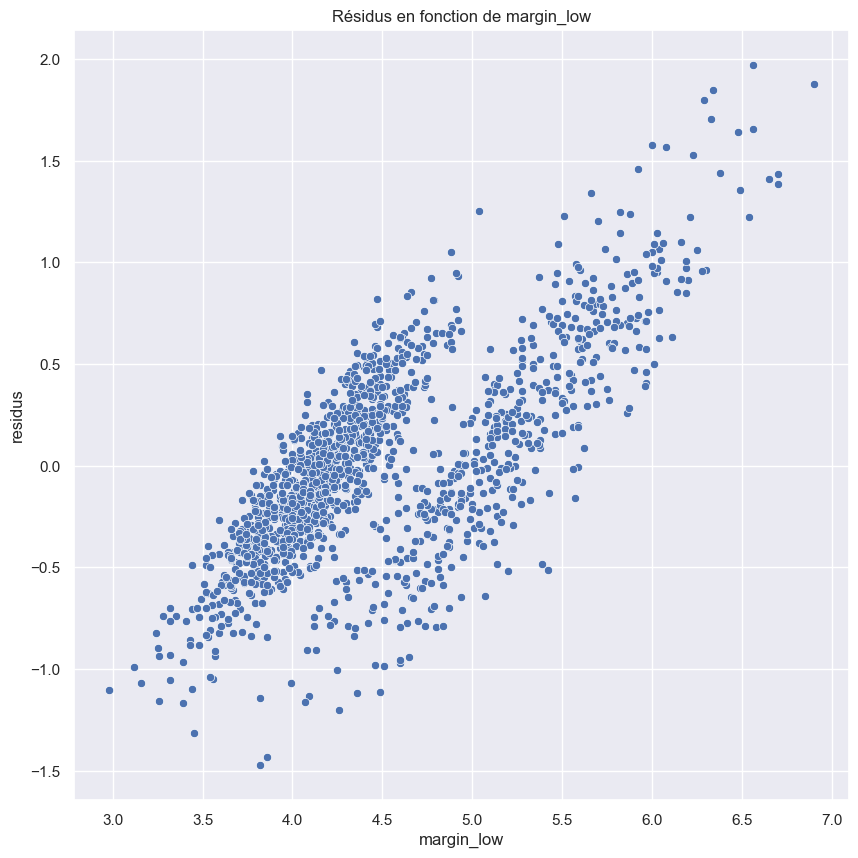

In [28]:
#Visualisation des résidus en fonction de margin_low
sns.scatterplot(data=billets_sans_na, x="margin_low", y='residus').set_title('Résidus en fonction de margin_low')
plt.show()

In [29]:
shapiro(reg_backward_All.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

L'hypothèse de normalité des résidus est rejetée.

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.


#### **Prédictions des valeurs de Marin_low**

In [30]:
a_prevoir_All = billetsNA
margin_low_prev_multi_All = reg_backward_All.predict(a_prevoir_All)
print(len(margin_low_prev_multi_All))


37


In [31]:
#Ajout des valeurs prédites au dataframe

billetsNA['margin_low']=margin_low_prev_multi_All

billets_corrigés_All = pd.concat([billets_sans_na,billetsNA], axis=0)

**Vérification de la cohéance**

In [32]:
billets_corrigés_All.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1500.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.483475     3.151473   
std       0.305195     0.299462      0.325627     0.659632     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.020000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length       residus  
count  1500.00000  1.463000e+03  
mean    112.67850  7.770802e-16  
std       0.87273  4.799064e-01  
min     109.49000 -1.472342e+00  
25%     112.03000 -3.170738e-01  
50%     112.96000 -4.168097e-02  
75%     113.34000  2.735290e-01  
max     114.44000  1.970836e+00

In [33]:
billets_sans_na.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1463.000000  1463.000000   1463.000000  1463.000000  1463.000000   
mean    171.959193   104.031333    103.921476     4.485967     3.153083   
std       0.305457     0.299605      0.324181     0.663813     0.231466   
min     171.040000   103.140000    102.910000     2.980000     2.270000   
25%     171.750000   103.825000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.315000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

            length       residus  
count  1463.000000  1.463000e+03  
mean    112.674757  7.770802e-16  
std       0.873222  4.799064e-01  
min     109.490000 -1.472342e+00  
25%     112.020000 -3.170738e-01  
50%     112.960000 -4.168097e-02  
75%     113.340000  2.735290e-01  
max     114.320000  1.970836e+00

Nous conservons une moyenne et un ecart-type très similaire. Implémentons ces correctifs pour le reste pour la mise en place des algorithmes.

In [34]:
billets_corrigés_All.drop(columns="residus",inplace=True)
df = billets_corrigés_All

## 4. Algorithmes et prédictions

Afin de mettre en place un algorithme de Marchin Learning, nous devons créer un set d'entrainement et un set de test.
On divise le dataset en 2 :
- 75% pour le jeu d'entrainement
- 25% pour le test de l'algorithme

In [35]:
#Définition de la taille du jeu de test
test_size = 0.25

x_train1, x_test1, y_train, y_test = train_test_split(df,df['is_genuine'], test_size=test_size, random_state=2)
#x_test1 et x_train1 pour conserver le 'is_genuine' afin de vérifier l'efficacité du test Kmeans
x_train = x_train1.iloc[:,1:]
x_test = x_test1.iloc[:,1:]

#### **Analyse des sets**

In [36]:
print('Forme du set x_train :',x_train.shape)
print('Forme du set y_train :',y_train.shape)
print('Dénombrement des vrais et faux billets :\n',y_train.value_counts())
print(separateur)
print('Forme du set x_test :',x_test.shape)
print('Forme du set y_test :',y_test.shape)
print('Dénombrement des vrais et faux billets :\n' ,y_test.value_counts())

Forme du set x_train : (1125, 6)
Forme du set y_train : (1125,)
Dénombrement des vrais et faux billets :
 True     758
False    367
Name: is_genuine, dtype: int64

---------------------------------------------
Forme du set x_test : (375, 6)
Forme du set y_test : (375,)
Dénombrement des vrais et faux billets :
 True     242
False    133
Name: is_genuine, dtype: int64


### 4.1. Prédiction par Régression Logistique et Evaluation

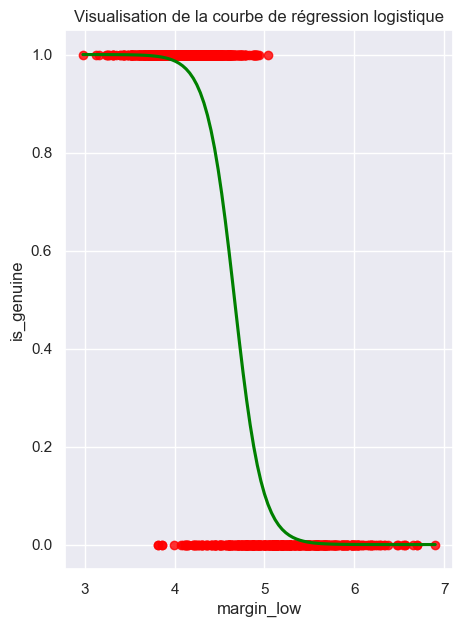

In [37]:
#Visualisation de la régression logistique
plt.figure(figsize=(5,7))
sns.regplot(df, x='margin_low', y='is_genuine',logistic=True, ci=None, scatter_kws={'color': 'red'}, line_kws={'color': 'green'})
plt.title('Visualisation de la courbe de régression logistique')
plt.show()

In [38]:
#Création de l'instance de régression logistique
logisticReg = LogisticRegression()
logisticReg.fit(x_train,y_train)

LogisticRegression()

In [39]:
#Prediction des valeurs test
y_pred_reglog = logisticReg.predict(x_test)

In [40]:
score_lr = round(metrics.accuracy_score(y_test,y_pred_reglog)*100,3)
proba_lr = logisticReg.predict_proba(x_test)
print('Score de la Régression Logistique :',score_lr)

Score de la Régression Logistique : 98.933


**Matrice de confusion**

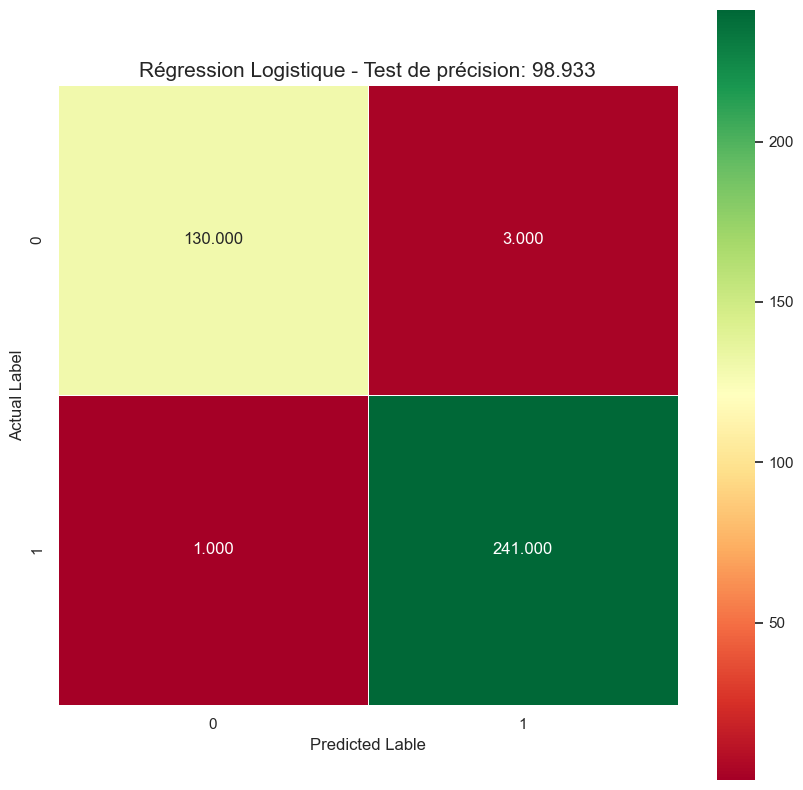

In [41]:
#Création de la matrice de confusion
cm_reg_log = metrics.confusion_matrix(y_test, y_pred_reglog)

#Visualisation
plt.figure(figsize=(10,10))
sns.heatmap(cm_reg_log,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Lable')
all_sample_title= 'Régression Logistique - Test de précision: {0}'.format(score_lr)
plt.title(all_sample_title, size=15)
plt.show()

### 4.2. Prédiction par K-NN et Evaluation

Mêmes données que la régression logistique, mais nous allons les standardiser.

In [42]:
sc_X = StandardScaler()
X_train_std = sc_X.fit_transform(x_train)
X_test_std = sc_X.fit_transform(x_test)

In [43]:
#Choix du nombre de voisins
round(math.sqrt(len(y_test)),2)

19.36

In [44]:
#Définition du model: Init K-NN
n_neighbors=19
knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=2, metric='euclidean')

In [45]:
#Fit Model
knn.fit(X_train_std,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=19)

In [46]:
#Prédiction
Y_pred_knn = knn.predict(X_test_std)

In [47]:
score_knn = round(metrics.accuracy_score(y_test,Y_pred_knn)*100,3)
print('KNN - Score :',score_knn)

KNN - Score : 98.667


**Matrice de confusion**

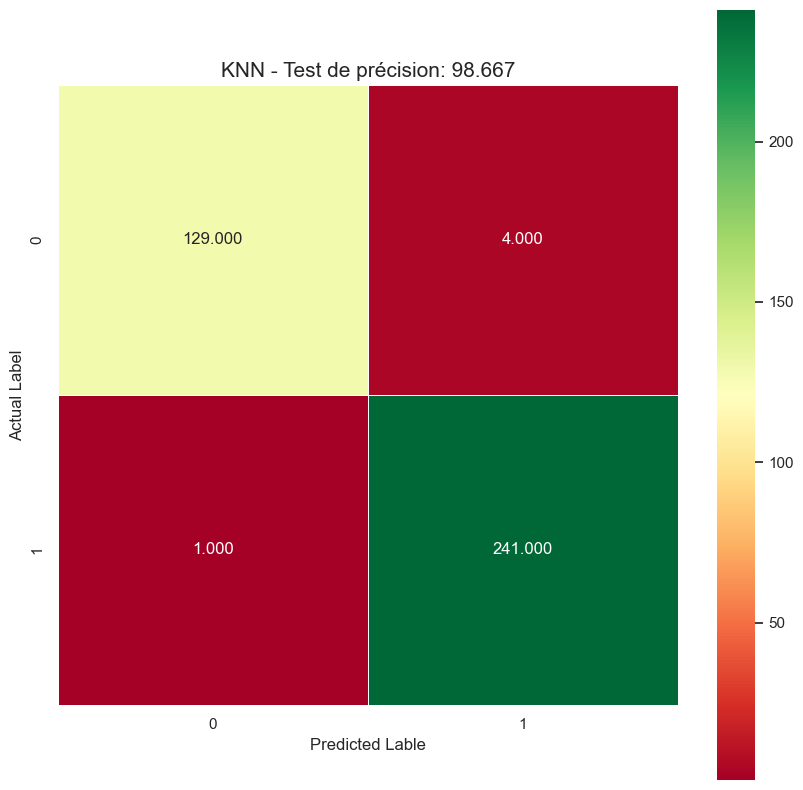

In [48]:
#Création de la matrice de confusion
cm_knn = metrics.confusion_matrix(y_test,Y_pred_knn)

#Visualisation
plt.figure(figsize=(10,10))
sns.heatmap(cm_knn,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Lable')
all_sample_title= 'KNN - Test de précision: {0}'.format(score_knn)
plt.title(all_sample_title, size=15)
plt.show()

Le Knn permet une prédiction efficace, néanmoins légèrement inférieure  à la régression logistique.

### 4.3. Prédiction par K-means et Evaluation

Pour le K-means, nous utiliserons également les données standardisées. 

Regardons tout d'abord si le modèle est cohérant avec 2 clusters.

**Elbow Curve**

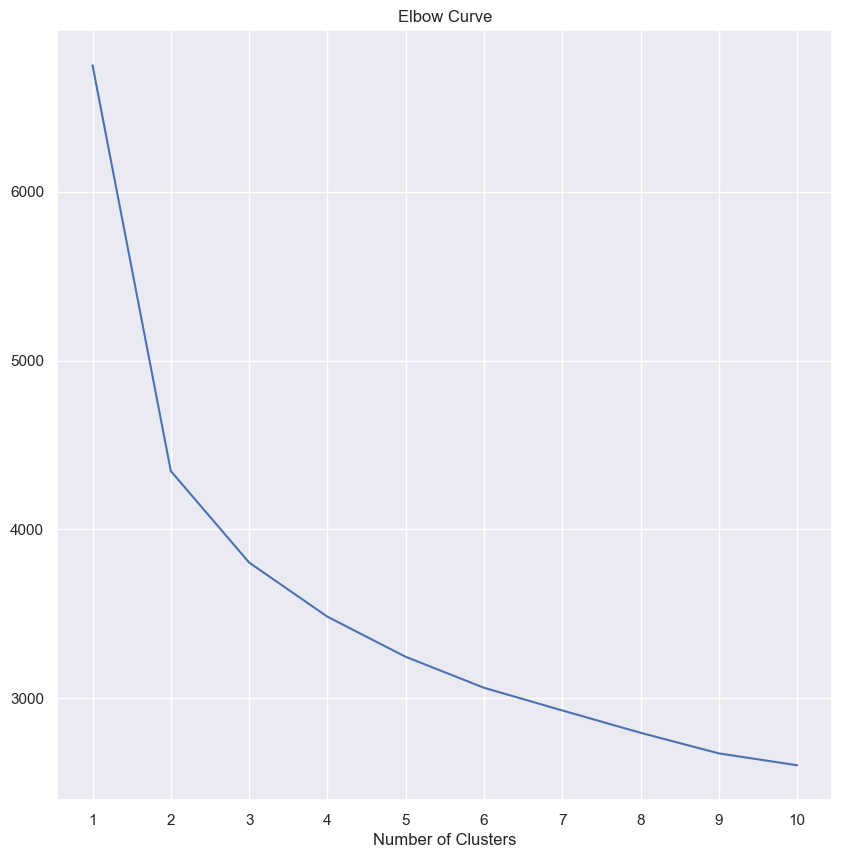

In [49]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 2,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_std)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.title('Elbow Curve')
plt.show()

Nous avons bien un coude à 2 clusters.

Initialisons l'algorithme avec le **set d'entrainement**

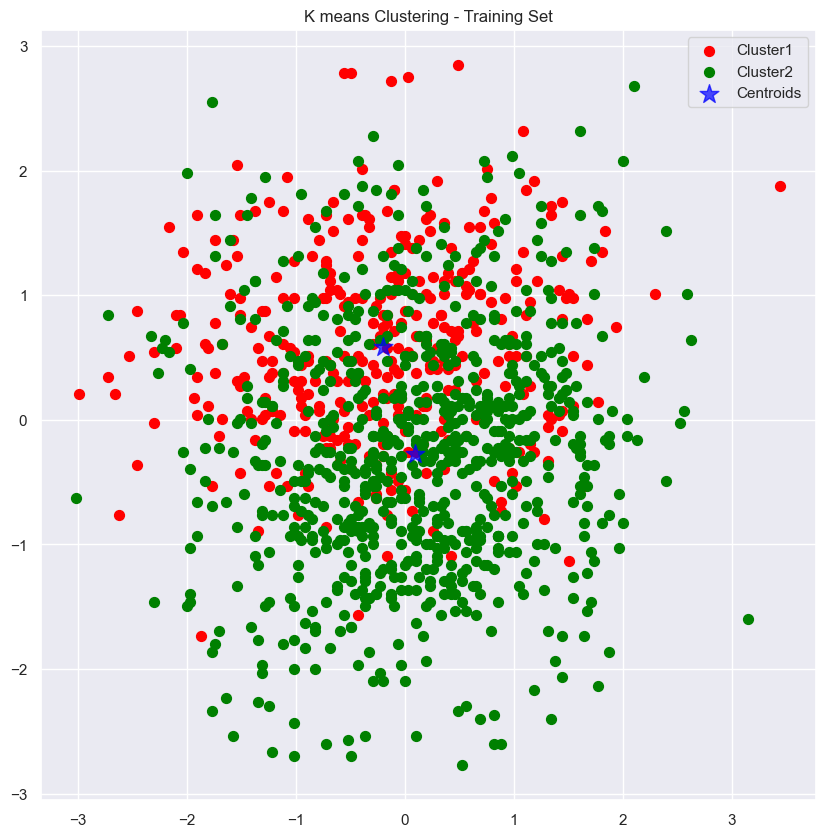

In [50]:
km=KMeans(n_clusters=2,init='random', max_iter=300, n_init=10, random_state=2)
y_means = km.fit_predict(X_train_std)
#Visulalisons le résultat
plt.scatter(X_train_std[y_means==0,0],X_train_std[y_means==0,1],s=50, c='red',label='Cluster1')
plt.scatter(X_train_std[y_means==1,0],X_train_std[y_means==1,1],s=50, c='green',label='Cluster2')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],s=200,marker='*', c='blue', alpha=0.7, label='Centroids')
plt.title('K means Clustering - Training Set')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

La visualisation ne permet pas de distinguer vraiement les clusters. Voyons s'ils sont cohérantes avec les attentes.

In [51]:
xmeans_train = x_train1
xmeans_train.loc[:,"cluster Kmeans"] = km.labels_

In [52]:
xmeans_train = xmeans_train[['margin_low','is_genuine','cluster Kmeans']]
xmeans_train.head()

margin_low  is_genuine  cluster Kmeans
491         4.10        True               1
548         4.19        True               1
570         3.82        True               1
1169        6.48       False               0
808         4.11        True               1

In [53]:
xmeans_train_valide=pd.pivot_table(data=xmeans_train, index=['cluster Kmeans'], columns=['is_genuine'], aggfunc='count').T
xmeans_train_valide

cluster Kmeans           0    1
           is_genuine          
margin_low False       355   12
           True          7  751

Nous voyons déjà quelques erreures de prédictions. Voyons l'efficacité sur le **set de Test**.

In [54]:
y_pred_km=km.predict(X_test_std)
print(len(y_pred_km))

375


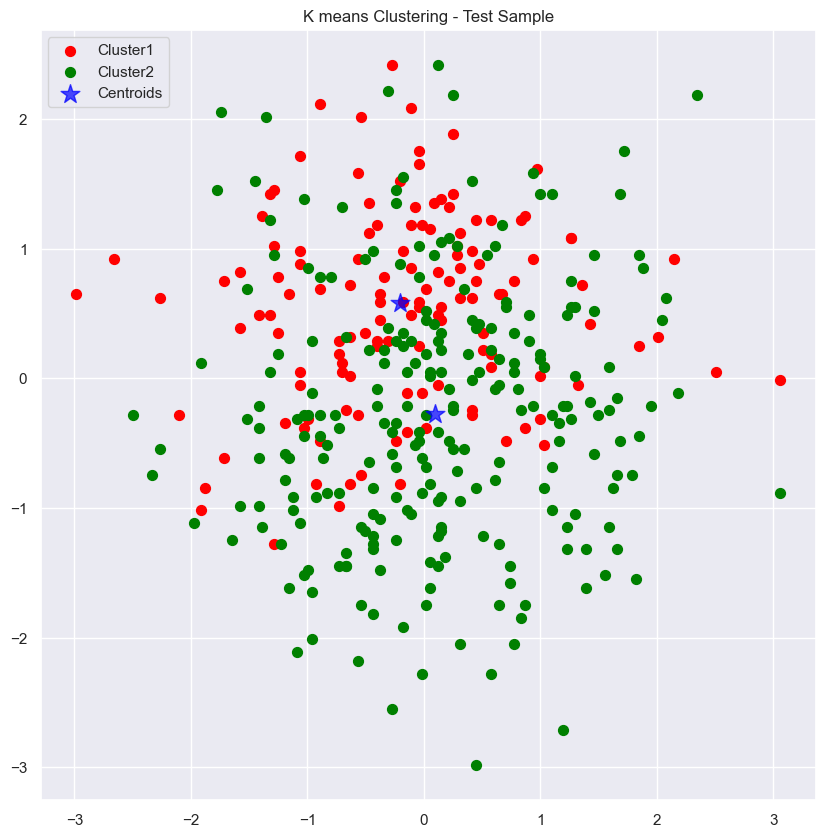

In [55]:
plt.scatter(X_test_std[y_pred_km==0,0],X_test_std[y_pred_km==0,1],s=50, c='red',label='Cluster1')
plt.scatter(X_test_std[y_pred_km==1,0],X_test_std[y_pred_km==1,1],s=50, c='green',label='Cluster2')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],s=200,marker='*', c='blue', alpha=0.7, label='Centroids')
plt.title('K means Clustering - Test Sample')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

In [56]:
xmeans_test = x_test1
xmeans_test.loc[:,"cluster Kmeans"] = y_pred_km

In [57]:
score_km = round(metrics.accuracy_score(y_test,y_pred_km)*100,3)
print('K-means - Score :',score_km)

K-means - Score : 98.667


**Matrice de Confusion**

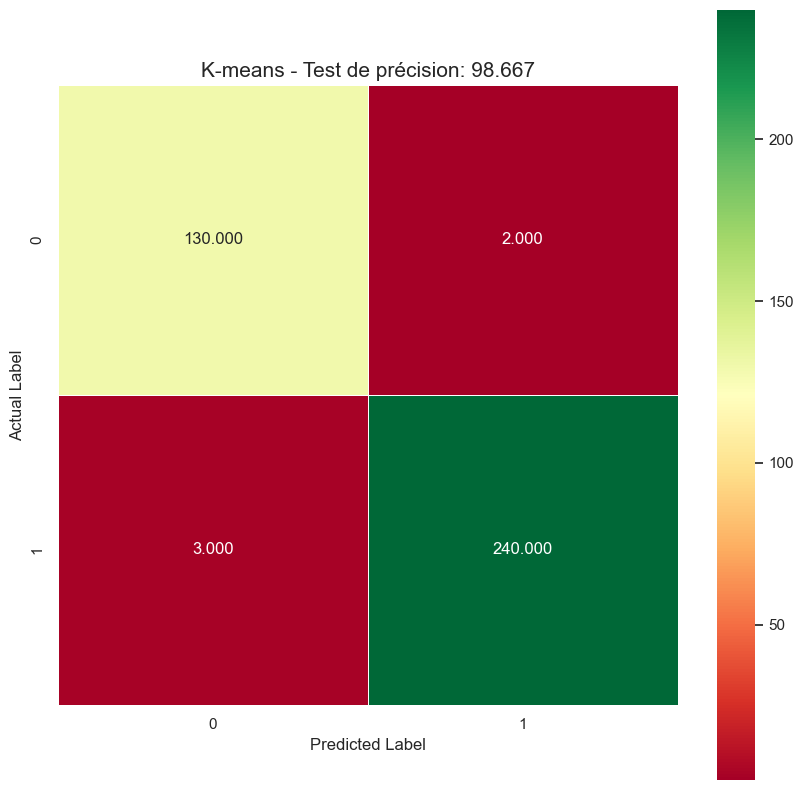

In [58]:
xmeans_test_valide=pd.pivot_table(data=xmeans_test, index=['cluster Kmeans'], columns=['is_genuine'], aggfunc='count')
cm_kmeans = xmeans_test_valide['diagonal'].to_numpy()

#Visualisation
plt.figure(figsize=(10,10))
sns.heatmap(cm_kmeans,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title= 'K-means - Test de précision: {0}'.format(score_km)
plt.title(all_sample_title, size=15)
plt.show()

Le K-means permet également une prédiction efficace, ici à la hauteur du KNN, légèrement inférieure à la régression logistique.

Mettons les 3 côte à côte

In [59]:
print(f"Régression logistique : {round(score_lr,2)}% ,KNN : {round(score_knn,2)}% , Kmeans : {round(score_km,2)}%")

Régression logistique : 98.93% ,KNN : 98.67% , Kmeans : 98.67%


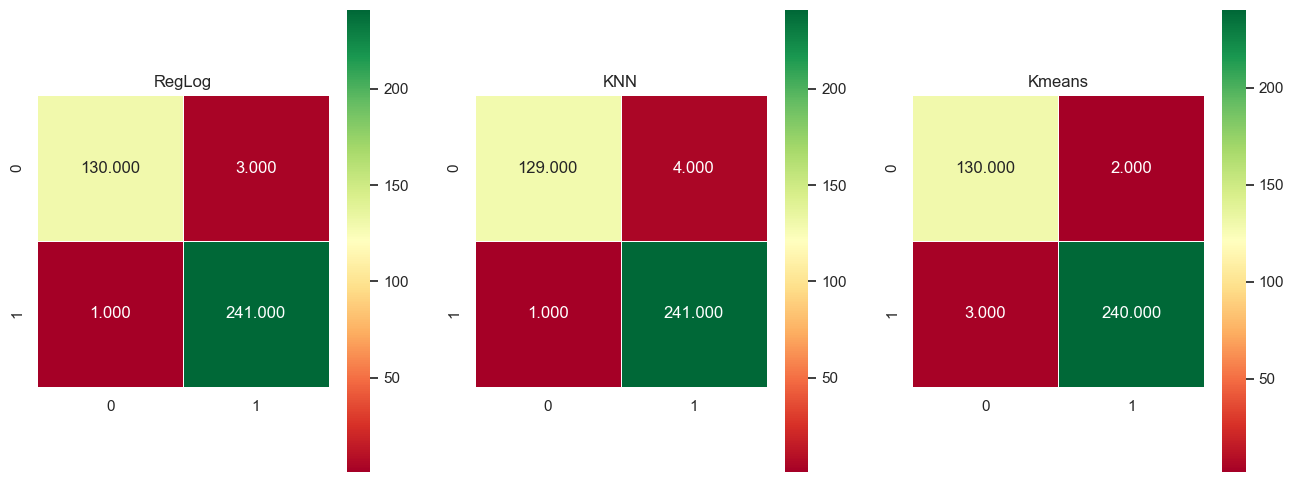

In [60]:
fig, axs = plt.subplots(ncols=3,figsize=(16,6))
sns.heatmap(cm_reg_log,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[0]).set(title='RegLog')
sns.heatmap(cm_knn,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[1]).set(title='KNN')
sns.heatmap(cm_kmeans,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[2]).set(title='Kmeans')
plt.show()

Les scores sont très élevés. La régression logistique est dans ce cas la plus efficace.

Des scores si élevés ne traduisent-ils pas un overfiting ? \
Testons en enlevant la variable la plus corrélée, *lenght*:

In [61]:
scores_test_overfit(df,'length')

Régression logistique : 94.13% ,KNN : 94.13% ,Kmeans : 95.73%


Les scores restent très importants. La variable *lenght* peut être considiérée comme dispensable pour la prédiction. Dans ce cas, le K-means est légèrement plus efficace.

Enlevons également la variable avec des valeurs nulles *maring_low* :

In [62]:
scores_test_overfit(df,['length','margin_low'])

Régression logistique : 85.6% ,KNN : 86.93% ,Kmeans : 85.33%


Une efficacité à 85% indique qu'environ 1 billet sur 5 peut être mal intérprété. La perte d'éfficacité est trop élevée.

Enlevons uniquement *margin_low* :

In [63]:
scores_test_overfit(df,'margin_low')

Régression logistique : 97.87% ,KNN : 97.33% ,Kmeans : 96.53%


La variable *margin_low* est encore plus dispensable à la prédiction. Nous savons donc maintenant que nous pouvons prédire l'authanticité du billet avec efficacité sans la variable *margin_low* qui est parfois manquante. 

Nous choisissons la solution consistant à conserver *margin_low* et enlever *lenght* pour un algorithme plus robuste à l'avenir.

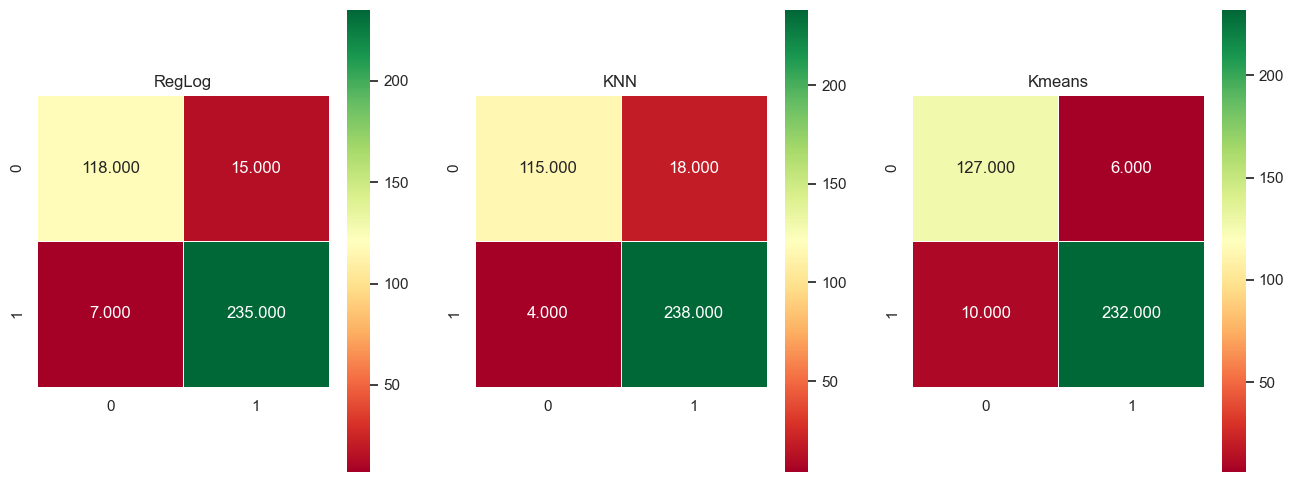

In [64]:
#On copie un nouveau dataframe sans la variable
df_test_overfit=df.drop(columns='length')

    #On crée nos set d'entrainement et de test
x_train1_over, x_test1_over, y_train_over, y_test_over = train_test_split(df_test_overfit,df_test_overfit['is_genuine'], test_size=test_size, random_state=2)
x_train_over = x_train1_over.iloc[:,1:]
x_test_over = x_test1_over.iloc[:,1:]
    #Regression logistique
logisticReg_over = LogisticRegression()
logisticReg_over.fit(x_train_over,y_train_over)
y_pred_reglog_over = logisticReg_over.predict(x_test_over)
    #KNN
X_train_std_over = sc_X.fit_transform(x_train_over)
X_test_std_over = sc_X.fit_transform(x_test_over)
knn_over = KNeighborsClassifier(n_neighbors=n_neighbors, p=2, metric='euclidean')
knn_over.fit(X_train_std_over,y_train_over)
Y_pred_knn_over = knn_over.predict(X_test_std_over)
    #Kmeans
km_over=KMeans(n_clusters=2,init='random', max_iter=300, n_init=10, random_state=51)
y_means_over = km_over.fit_predict(X_train_std_over)
y_pred_km_over=km_over.predict(X_test_std_over)

    #Scores
score_lr_over = metrics.accuracy_score(y_test_over,y_pred_reglog_over)
score_knn_over = metrics.accuracy_score(y_test_over,Y_pred_knn_over)
if metrics.accuracy_score(y_test_over,y_pred_km_over)>0.5:
    score_km_over = metrics.accuracy_score(y_test_over,y_pred_km_over)
else : score_km_over = 1-metrics.accuracy_score(y_test_over,y_pred_km_over)

    #Confusion matrix
cm_reg_log_over = metrics.confusion_matrix(y_test, y_pred_reglog_over)
cm_knn_over = metrics.confusion_matrix(y_test_over,Y_pred_knn_over)
cm_kmeans_over = metrics.confusion_matrix(y_test_over,y_pred_km_over)

fig, axs = plt.subplots(ncols=3,figsize=(16,6))
sns.heatmap(cm_reg_log_over,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[0]).set(title='RegLog')
sns.heatmap(cm_knn_over,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[1]).set(title='KNN')
sns.heatmap(cm_kmeans_over,annot=True,fmt=".3f",linewidths=.5,square=True,cmap='RdYlGn',ax=axs[2]).set(title='Kmeans')
plt.show()


## 5. Choix de l’algorithme et Test final sur données fournies

Aggrégons les résultats des prédictions et mettons en place un scoring simple.

In [65]:
comparaison = []
comparaison = pd.DataFrame(y_test, columns=['is_genuine'])
comparaison['RegLog'] = y_pred_reglog
comparaison['RegLog_Score'] = np.where(comparaison['is_genuine']==comparaison['RegLog'],1 ,0)

comparaison['KNN'] = Y_pred_knn
comparaison['KNN_Score'] = np.where(comparaison['is_genuine']==comparaison['KNN'],1 ,0)

comparaison['Kmeans'] = y_pred_km
comparaison['Kmeans_Score'] = np.where(comparaison['is_genuine']==comparaison['Kmeans'],1 ,0)

comparaison['RegLog_over'] = y_pred_reglog_over
comparaison['RegLog_over_Score'] = np.where(comparaison['is_genuine']==comparaison['RegLog_over'],1 ,0)

comparaison['KNN_over'] = Y_pred_knn_over
comparaison['KNN_over_Score'] = np.where(comparaison['is_genuine']==comparaison['KNN_over'],1 ,0)

comparaison['Kmeans_over'] = y_pred_km_over
comparaison['Kmeans_over_Score'] = np.where(comparaison['is_genuine']==comparaison['Kmeans_over'],1 ,0)

comparaison

is_genuine  RegLog  RegLog_Score    KNN  KNN_Score  Kmeans  \
736         True    True             1   True          1       1   
1473       False   False             1  False          1       0   
1309       False   False             1  False          1       0   
69          True    True             1   True          1       1   
278         True    True             1   True          1       1   
...          ...     ...           ...    ...        ...     ...   
15          True    True             1   True          1       1   
161         True    True             1   True          1       1   
780         True    True             1   True          1       1   
734         True    True             1   True          1       1   
1357       False   False             1  False          1       0   

      Kmeans_Score  RegLog_over  RegLog_over_Score  KNN_over  KNN_over_Score  \
736              1         True                  1      True               1   
1473             1        False                  1     False               1   
1309             1        False                  1     False               1   
69               1         True                  1      True               1   
278              1         True                  1      True               1   
...            ...          ...                ...       ...             ...   
15               1         True                  1      True               1   
161              1         True                  1      True               1   
780              1         True                  1      True               1   
734              1         True                  1      True               1   
1357             1        False                  1     False               1   

      Kmeans_over  Kmeans_over_Score  
736             1                  1  
1473            0                  1  
1309            0                  1  
69              1                  1  
278             1                  1  
...           ...                ...  
15              1                  1  
161             1                  1  
780             1                  1  
734             1                  1  
1357            0                  1  

[375 rows x 13 columns]

Visualisons l'efficacité sous forme de Roc Curve et affichons l'auc pour les algorithmes sur toutes les données

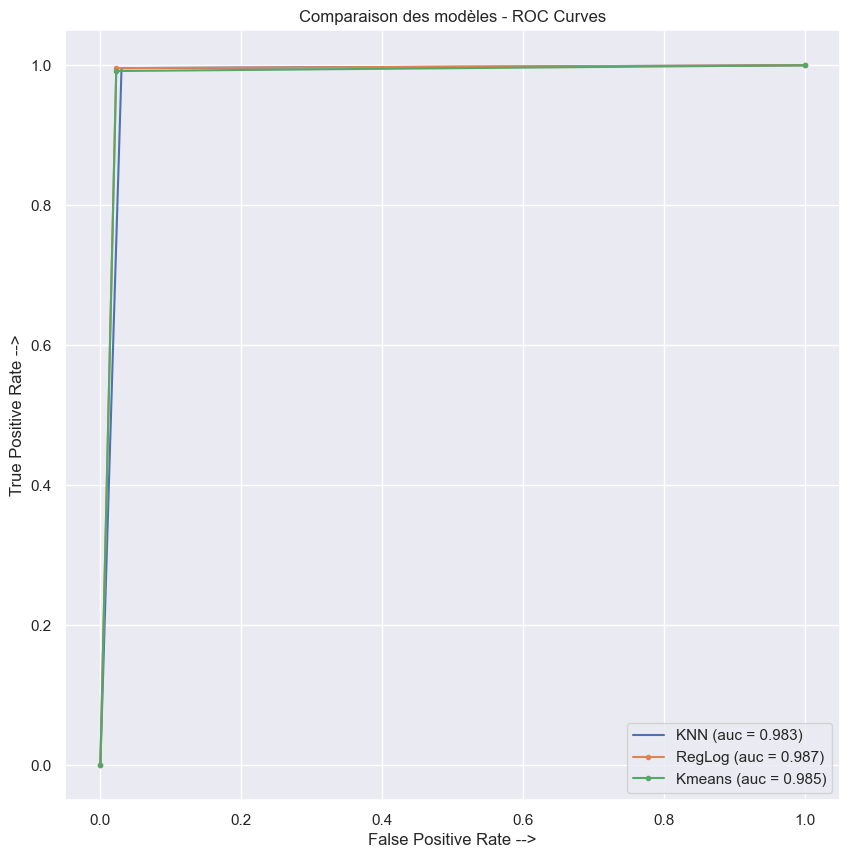

In [66]:
# roc curve pour les différents algorithmes
#LR
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_reglog)
auc_logistic = auc(logistic_fpr, logistic_tpr)
#KNN
knn_fpr, knn_tpr, threshold = roc_curve(y_test, Y_pred_knn)
auc_knn = auc(knn_fpr, knn_tpr)
#Kmeans
km_fpr, km_tpr, threshold = roc_curve(y_test, y_pred_km)
auc_km = auc(km_fpr, km_tpr)


plt.figure(figsize=(10, 10), dpi=100)
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='RegLog (auc = %0.3f)' % auc_logistic)
plt.plot(km_fpr, km_tpr, marker='.', label='Kmeans (auc = %0.3f)' % auc_km)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('Comparaison des modèles - ROC Curves')
plt.legend()

plt.show()

Visualisons l'efficacité sous forme de Roc Curve et affichons l'auc pour les données sans *length*

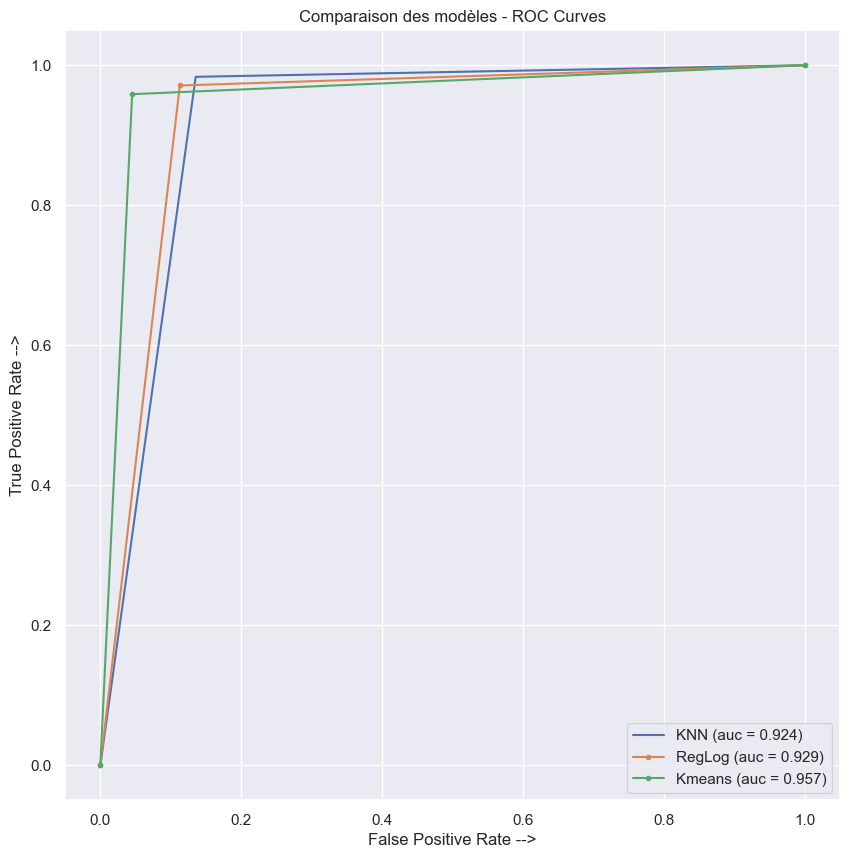

In [67]:
# roc curve pour les différents algorithmes
#LR
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_reglog_over)
auc_logistic = auc(logistic_fpr, logistic_tpr)
#KNN
knn_fpr, knn_tpr, threshold = roc_curve(y_test, Y_pred_knn_over)
auc_knn = auc(knn_fpr, knn_tpr)
#Kmeans
km_fpr, km_tpr, threshold = roc_curve(y_test, y_pred_km_over)
auc_km = auc(km_fpr, km_tpr)


plt.figure(figsize=(10, 10), dpi=100)
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN (auc = %0.3f)' % auc_knn)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='RegLog (auc = %0.3f)' % auc_logistic)
plt.plot(km_fpr, km_tpr, marker='.', label='Kmeans (auc = %0.3f)' % auc_km)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('Comparaison des modèles - ROC Curves')
plt.legend()

plt.show()

Visualisons les erreurs de prédictions sous forme de heatmap

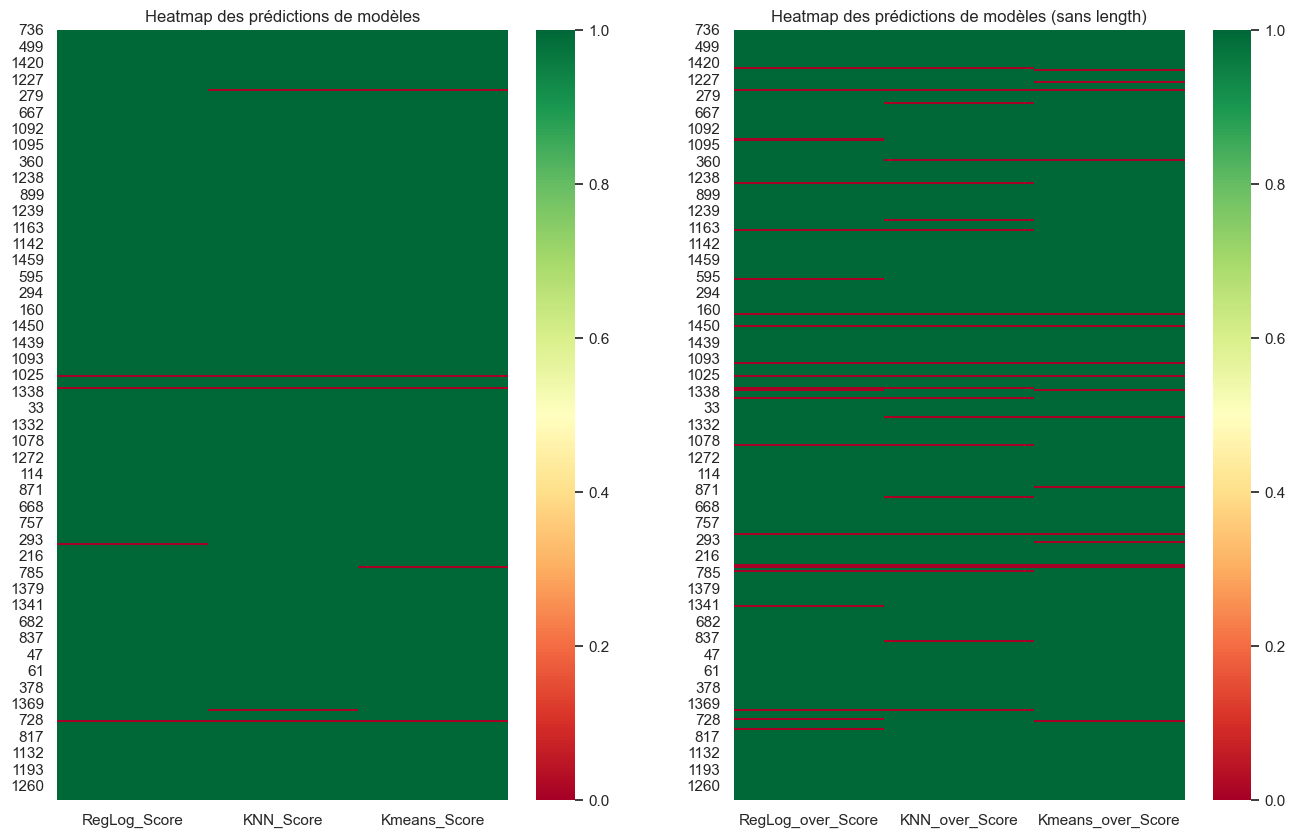

In [80]:
# heatmap des prédictions
ModelNotes = comparaison[['RegLog_Score', 'KNN_Score', 'Kmeans_Score']]
ModelNotes_over = comparaison[['RegLog_over_Score', 'KNN_over_Score', 'Kmeans_over_Score']]
fig, axs= plt.subplots(ncols=2,figsize=(16,10))
sns.heatmap(ModelNotes, cmap='RdYlGn',ax=axs[0]).set_title('Heatmap des prédictions de modèles')
sns.heatmap(ModelNotes_over, cmap='RdYlGn',ax=axs[1]).set_title('Heatmap des prédictions de modèles (sans length)')
plt.show()

Visualisons les également en scatterplot

In [69]:
comparaison = pd.concat([comparaison,x_test],axis=1)

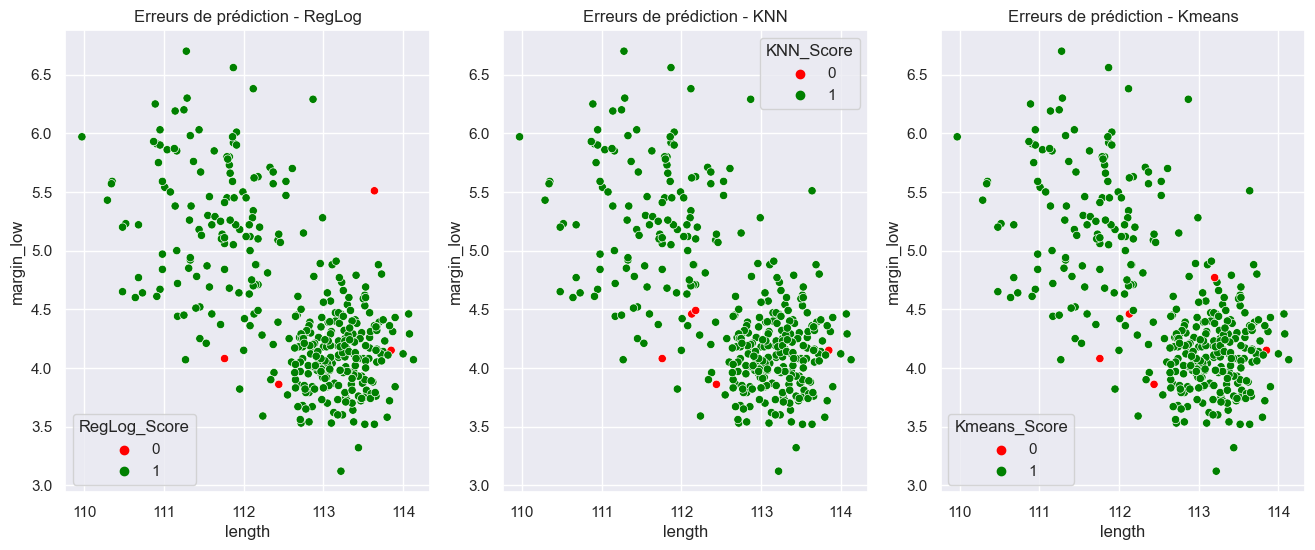

In [70]:
fig, axs = plt.subplots(ncols=3,figsize=(16,6))
sns.scatterplot(comparaison,x='length',y='margin_low',hue='RegLog_Score',ax=axs[0],palette=palet).set(title='Erreurs de prédiction - RegLog')
sns.scatterplot(comparaison,x='length',y='margin_low',hue='KNN_Score',ax=axs[1],palette=palet).set(title='Erreurs de prédiction - KNN')
sns.scatterplot(comparaison,x='length',y='margin_low',hue='Kmeans_Score',ax=axs[2],palette=palet).set(title='Erreurs de prédiction - Kmeans')
plt.show()

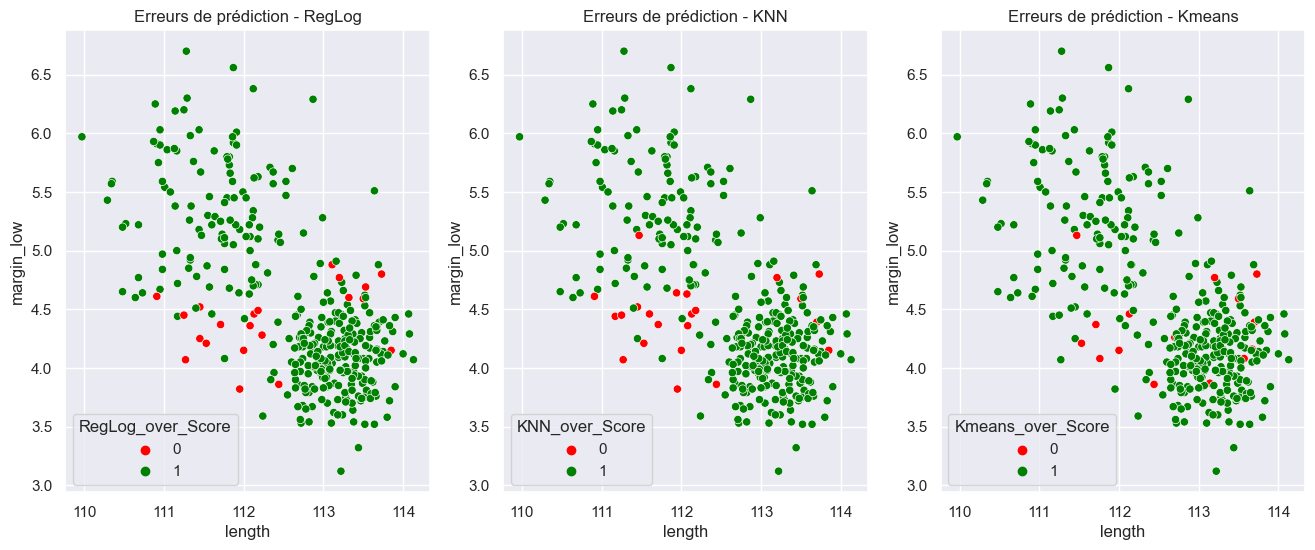

In [71]:
fig, axs = plt.subplots(ncols=3,figsize=(16,6))
sns.scatterplot(comparaison,x='length',y='margin_low',hue='RegLog_over_Score',ax=axs[0],palette=palet).set(title='Erreurs de prédiction - RegLog')
sns.scatterplot(comparaison,x='length',y='margin_low',hue='KNN_over_Score',ax=axs[1],palette=palet).set(title='Erreurs de prédiction - KNN')
sns.scatterplot(comparaison,x='length',y='margin_low',hue='Kmeans_over_Score',ax=axs[2],palette=palet).set(title='Erreurs de prédiction - Kmeans')
plt.show()

Listons les individus concernées.

In [72]:
erreur_reglog = comparaison[comparaison["RegLog_Score"] == 0].index.tolist()
print(f'Nombre Erreur RegLog : {len(erreur_reglog)} ')
print(erreur_reglog)
print(separateur)
erreur_knn = comparaison[comparaison["KNN_Score"] == 0].index.tolist()
print(f'Nombre Erreur KNN : {len(erreur_knn)} ')
print(erreur_knn)
print(separateur)
erreur_km = comparaison[comparaison["Kmeans_Score"] == 0].index.tolist()
print(f'Nombre Erreur Kmeans : {len(erreur_km)} ')
print(erreur_km)
print(separateur)
print(f"Erreurs sur les 3 modèles :{len(set(erreur_reglog)&set(erreur_knn)&set(erreur_km))}")
print(set(erreur_reglog)&set(erreur_knn)&set(erreur_km))


Nombre Erreur RegLog : 4 
[1025, 1122, 1325, 728]

---------------------------------------------
Nombre Erreur KNN : 5 
[1084, 1025, 1122, 1307, 728]

---------------------------------------------
Nombre Erreur Kmeans : 5 
[1084, 1025, 1122, 341, 728]

---------------------------------------------
Erreurs sur les 3 modèles :3
{728, 1025, 1122}


In [73]:
erreur_reglog = comparaison[comparaison["RegLog_over_Score"] == 0].index.tolist()
print(f'Nombre Erreur RegLog : {len(erreur_reglog)} ')
print(erreur_reglog)
print(separateur)
erreur_knn = comparaison[comparaison["KNN_over_Score"] == 0].index.tolist()
print(f'Nombre Erreur KNN : {len(erreur_knn)} ')
print(erreur_knn)
print(separateur)
erreur_km = comparaison[comparaison["Kmeans_over_Score"] == 0].index.tolist()
print(f'Nombre Erreur Kmeans : {len(erreur_km)} ')
print(erreur_km)
print(separateur)
print(f"Erreurs sur les 3 modèles :{len(set(erreur_reglog)&set(erreur_knn)&set(erreur_km))}")
print(set(erreur_reglog)&set(erreur_knn)&set(erreur_km))


Nombre Erreur RegLog : 22 
[1333, 1084, 1416, 1158, 1252, 269, 1010, 1450, 977, 1025, 1122, 197, 1245, 1006, 1472, 239, 341, 1009, 1341, 1307, 791, 557]

---------------------------------------------
Nombre Erreur KNN : 22 
[1333, 1084, 1094, 905, 1158, 1044, 1252, 1010, 1450, 977, 1025, 1122, 1245, 1354, 1006, 1499, 1472, 239, 341, 1009, 1440, 1307]

---------------------------------------------
Nombre Erreur Kmeans : 16 
[476, 441, 1084, 905, 1010, 1450, 977, 1025, 197, 1354, 252, 1472, 459, 239, 341, 728]

---------------------------------------------
Erreurs sur les 3 modèles :8
{1472, 1025, 1450, 239, 977, 1010, 341, 1084}


Nous choisissons donc l'algorithme le plus efficace dans l'ensemble, c'est à dire la regression logistique.

## **Test Final - Regression Logistique**

In [74]:
billets_a_verifier = pd.read_csv('billets_production.csv')
final_test = billets_a_verifier.iloc[: , :-1]
labels = billets_a_verifier['id'].to_list()


In [75]:
final_test

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33

In [76]:
labels

['A_1', 'A_2', 'A_3', 'A_4', 'A_5']

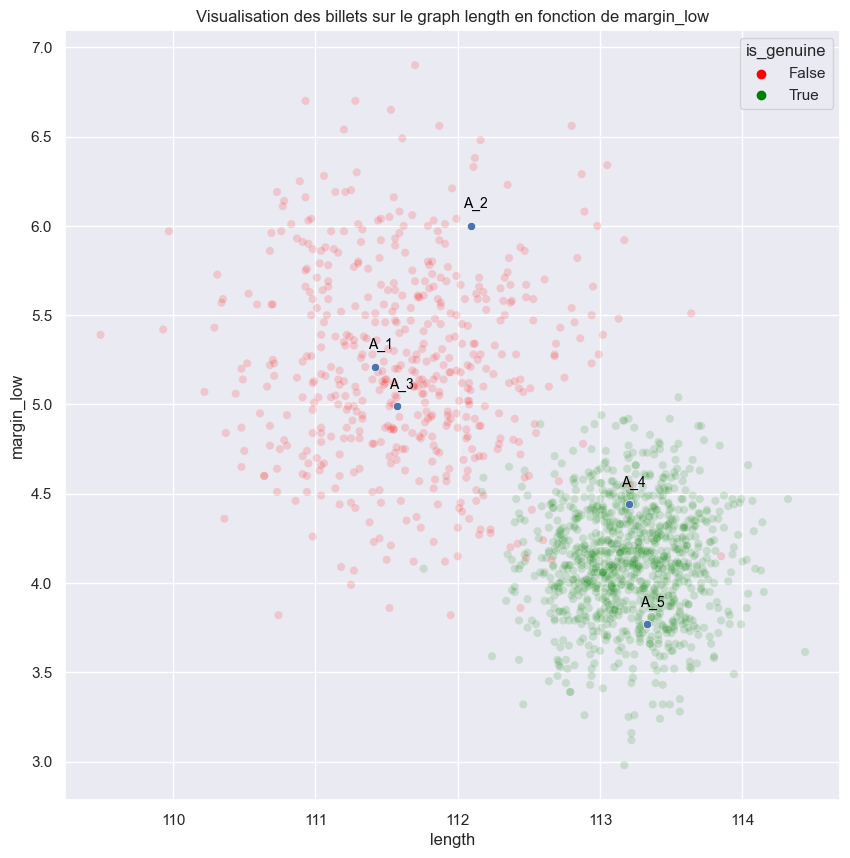

In [77]:
#Visualisons ces billets à tester sur le graph margin_low en fonction de length
sns.scatterplot(df,x='length',y='margin_low',hue='is_genuine',palette=palet,alpha=0.15,legend=True)
sns.scatterplot(billets_a_verifier,x='length',y='margin_low',legend=False,color='b', marker ='o')

for i in range(billets_a_verifier.shape[0]):
    plt.text(x=billets_a_verifier.length[i]-0.05,y=billets_a_verifier.margin_low[i]+0.1,s=billets_a_verifier.id[i], 
          fontdict=dict(color='black',size=10))
plt.title("Visualisation des billets sur le graph length en fonction de margin_low")
plt.show()

Prédiction en tenant compte de toutes les données

In [78]:
#Régression logistique
predictions_RL = logisticReg.predict(final_test)
billets_a_verifier.loc[:,"Prediction_RL"] = predictions_RL


# extraction des pourcentages
percent = logisticReg.predict_proba(final_test)
percent = pd.DataFrame(percent)
# mise en forme
percent = round(percent,2)*100


# concaténation avec l'id du billet fourni
test_results = pd.concat([billets_a_verifier[['id','Prediction_RL']], percent], axis=1)
test_results.rename(columns={0:"Faux_Billet",1:"Vrai_Billet"},inplace=True)
print(test_results)

    id  Prediction_RL  Faux_Billet  Vrai_Billet
0  A_1          False        100.0          0.0
1  A_2          False        100.0          0.0
2  A_3          False        100.0          0.0
3  A_4           True          8.0         92.0
4  A_5           True          0.0        100.0


Prédiction en cas d'absence de *length*

In [79]:
final_test_corrige = final_test.copy()
final_test_corrige.drop(columns=['length'],inplace=True)
#Regression Logistique
predictions_RL = logisticReg_over.predict(final_test_corrige)
predictions = billets_a_verifier.copy()
predictions.loc[:,"Prediction_RL"] = predictions_RL


# extraction des pourcentages
percent = logisticReg_over.predict_proba(final_test_corrige)
percent = pd.DataFrame(percent)
# mise en forme
percent = round(percent,2)*100


# concaténation avec l'id du billet fourni
predictions_results = pd.concat([predictions[['id','Prediction_RL']], percent], axis=1)
predictions_results.rename(columns={0:"Faux_Billet",1:"Vrai_Billet"},inplace=True)
print(predictions_results)

    id  Prediction_RL  Faux_Billet  Vrai_Billet
0  A_1          False         94.0          6.0
1  A_2          False        100.0          0.0
2  A_3          False         97.0          3.0
3  A_4           True         11.0         89.0
4  A_5           True          0.0        100.0
